In [36]:
FILE_PATH_DATA = 'data/dryad/FingerDecodingQuadcopterData/data/'
OUTPUT_FIG_DIR = 'plot'

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import scipy.io as sio
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from scipy import interpolate
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqz
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from PIL import Image
%matplotlib inline

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.insert(1, '.')
import NNDecoders as nd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Choose Device

dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [38]:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='low')
    return b, a

In [39]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [40]:
def LoadData(filename, filepath, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, zScore=False):
    # Load Data
    inData = sio.loadmat(filepath+filename)

    binPos = inData['binned_taskOutput_stream_estimated']
    binTime = inData['binned_taskOutput_stream_redis_clock'][0,:]
    binTarg = inData['binned_taskOutput_stream_target'][:,FingSel]
    binTrial = inData['binned_taskOutput_stream_hand_color'][:,0:1]
    binNeural = inData['binnedNeural_hlfp']
    binNeuralTime = inData['binnedNeural_redisClock'][:,0]
    
    if zScore:
        # First 80 samples are noisy 
        binNeural = binNeural[80:,:]
        binNeuralTime = binNeuralTime[80:]
        
        # Don't normalize the channels with zero standard deviation
        binNeural = (binNeural-np.mean(binNeural,axis=0))
        stDevValue = np.std(binNeural,axis=0)
        indNonZero = stDevValue!=0
        binNeural[:,indNonZero]=binNeural[:,indNonZero]/stDevValue[indNonZero]

    binNeural = binNeural[(binNeuralTime > np.min(binTime)) & (binNeuralTime < np.max(binTime)),:]
    binNeuralTime = binNeuralTime[(binNeuralTime > np.min(binTime)) & (binNeuralTime < np.max(binTime))]
    
    f_pos = interpolate.interp1d(binTime, binPos, axis=0, kind='linear')
    binPos = f_pos(binNeuralTime)
    
    # have to multiple by 1000 because binNeuralTime is in ms
    binVel = 1e3*np.append(np.transpose(np.transpose(np.diff(binPos,axis=0))/np.diff(binNeuralTime,axis=0)),np.zeros([1,numFings]),axis=0)

    f_targ = interpolate.interp1d(binTime, binTarg, axis=0, kind='linear')
    binTarg = f_targ(binNeuralTime)

    f_trial = interpolate.interp1d(binTime, binTrial, axis=0, kind='linear')
    binTrial = f_targ(binNeuralTime)
    
    return inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial

In [49]:
def PlotTargetTrajectories(filename, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], dt=0.05, fig_fn='TargetTraj',plot2D=False):
    
    ts = 0
    nDOF = np.array(range(len(FingSel)))
    
    FingTest = np.array([0,1,2,5])
    
    inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial = LoadData(filename, filepath)
    
    # Bin Time
    idx = np.array(range(len(binTarg)))
    
    # Target Size
    Target_Size = 2*float(inData['fn_hold_threshold'])

    # Nonzero when the target has changed position
    TranLog = np.append(np.zeros([1]), np.sum(np.abs(np.diff(binTarg,axis=0)),1),axis=0)

    # Start time of each trial and start index
    BegTargTime = np.append(binNeuralTime[:1],binNeuralTime[TranLog != 0],axis=0)
    BegTargTime_idx = np.append(np.array([0]),idx[TranLog != 0])

    # End time of each trial and last index
    EndTargTime = np.append(BegTargTime[1:]-dt,binNeuralTime[-1:],axis=0)
    EndTargTime_idx = np.append(BegTargTime_idx[1:]-1,[binTarg.shape[0]-1],axis=0)

    AllTargs = binTarg[BegTargTime_idx,:]
    fig = plt.figure(facecolor='white')
    
    for k in range(len(FingSel)):
        
        ax=plt.subplot(4,1,k+1)
        k_FingSel = np.where(FingSel[k]==FingTest)[0][0]
        for kk in range(AllTargs.shape[0]):
            rect = patches.Rectangle(((BegTargTime[kk]-binNeuralTime[0]-ts)/1000, AllTargs[kk,k_FingSel]-Target_Size/2), (EndTargTime[kk]-BegTargTime[kk])/1000, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
            ax.add_patch(rect)
        
        plt.plot((binNeuralTime-binNeuralTime[0]-ts)*1e-3,binPos[:,FingSel[k]])

        plt.xlim(0, 100)
        plt.ylim(-.15,1.15)
        plt.yticks((0,.5,1),(0,50,100),fontsize=14)
        plt.xticks(fontsize=14)
        
        if k < len(FingSel)-1:
            plt.xticks((),())
        plt.ylabel('% Flex',fontsize=18)
        
        if FingSel[k]==1:
            plt.ylabel('% Abd',fontsize=18)

    plt.xlabel('Elapsed Time (s)',fontsize=18)

    fig.set_size_inches(12, 6, forward=True)
    plt.savefig(fig_fn+'.eps',dpi=300,facecolor=fig.get_facecolor(),format='eps')
    plt.savefig(fig_fn+'.jpg',dpi=300,facecolor=fig.get_facecolor(),format='jpg')
    
    
    if plot2D:
        
        fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
        
        ax1 = plt.subplot(2,2,4,aspect='equal')
        ax1 = plt.gca()
        for kk in range(2,AllTargs.shape[0]):
            if (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 > 0.3**2) and (AllTargs[kk-1,0]==0.5 and AllTargs[kk-1,1]==0.5):
                idx = np.array(range(BegTargTime_idx[kk],EndTargTime_idx[kk+1]))
                plt.plot(binPos[idx,FingSel[0]],binPos[idx,FingSel[1]])
                rect = patches.Rectangle((AllTargs[kk,0]-Target_Size/2, AllTargs[kk,1]-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
                ax1.add_patch(rect)
        rect = patches.Rectangle((0.5-Target_Size/2, 0.5-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
        ax1.add_patch(rect)
        plt.xlim(-.15,1.15)
        plt.ylim(-.15,1.15)
        plt.xticks((0,.5,1),(0,50,100),fontsize=14)
        plt.yticks((0,.5,1),(0,50,100),fontsize=14)
        plt.xlabel('% Flex',fontsize=18)
        plt.title('> 30%',fontsize=24,fontweight='bold')
        
        
        ax1 = plt.subplot(2,2,3,aspect='equal')
        ax1 = plt.gca()
        for kk in range(2,AllTargs.shape[0]):
            if (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 > 0.4**2) and (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 < 0.5**2) and (AllTargs[kk-1,0]==0.5 and AllTargs[kk-1,1]==0.5):
                idx = np.array(range(BegTargTime_idx[kk],EndTargTime_idx[kk+1]))
                plt.plot(binPos[idx,FingSel[0]],binPos[idx,FingSel[1]])
                rect = patches.Rectangle((AllTargs[kk,0]-Target_Size/2, AllTargs[kk,1]-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
                ax1.add_patch(rect)
        rect = patches.Rectangle((0.5-Target_Size/2, 0.5-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
        ax1.add_patch(rect)
        plt.xlim(-.15,1.15)
        plt.ylim(-.15,1.15)
        plt.xticks((0,.5,1),(0,50,100),fontsize=14)
        plt.yticks((0,.5,1),(0,50,100),fontsize=14)
        plt.xlabel('% Flex',fontsize=18)
        plt.ylabel('% Abd',fontsize=18)
        plt.title('40-50%',fontsize=24,fontweight='bold')

        ax1 = plt.subplot(2,2,2,aspect='equal')
        ax1 = plt.gca()
        for kk in range(2,AllTargs.shape[0]):
            if (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 > 0.3**2) and (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 < 0.4**2) and (AllTargs[kk-1,0]==0.5 and AllTargs[kk-1,1]==0.5):
                idx = np.array(range(BegTargTime_idx[kk],EndTargTime_idx[kk+1]))
                plt.plot(binPos[idx,FingSel[0]],binPos[idx,FingSel[1]])
                rect = patches.Rectangle((AllTargs[kk,0]-Target_Size/2, AllTargs[kk,1]-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
                ax1.add_patch(rect)
        rect = patches.Rectangle((0.5-Target_Size/2, 0.5-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
        ax1.add_patch(rect)
        plt.xlim(-.15,1.15)
        plt.ylim(-.15,1.15)
        plt.xticks((0,.5,1),(0,50,100),fontsize=14)
        plt.yticks((0,.5,1),(0,50,100),fontsize=14)
        plt.title('30-40%',fontsize=24,fontweight='bold')
        
        ax1 = plt.subplot(2,2,1,aspect='equal')
        ax1 = plt.gca()
        for kk in range(2,AllTargs.shape[0]):
            if (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 > 0.2**2) and (np.abs(AllTargs[kk,0]-AllTargs[kk-1,0])**2 + np.abs(AllTargs[kk,1]-AllTargs[kk-1,1])**2 < 0.3**2) and (AllTargs[kk-1,0]==0.5 and AllTargs[kk-1,1]==0.5):
                idx = np.array(range(BegTargTime_idx[kk],EndTargTime_idx[kk+1]))
                plt.plot(binPos[idx,FingSel[0]],binPos[idx,FingSel[1]])
                rect = patches.Rectangle((AllTargs[kk,0]-Target_Size/2, AllTargs[kk,1]-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
                ax1.add_patch(rect)
        rect = patches.Rectangle((0.5-Target_Size/2, 0.5-Target_Size/2),Target_Size, Target_Size, linewidth=1, edgecolor='k', facecolor='none')
        ax1.add_patch(rect)
        plt.xlim(-.15,1.15)
        plt.ylim(-.15,1.15)
        plt.xticks((0,.5,1),(0,50,100),fontsize=14)
        plt.yticks((0,.5,1),(0,50,100),fontsize=14)

        plt.ylabel('% Abd',fontsize=18)
        plt.title('20-30%',fontsize=24,fontweight='bold')
        
        fig2.tight_layout()
        
        plt.savefig(fig_fn+'_Thumb'+'.pdf',dpi=900,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='pdf')
        plt.savefig(fig_fn+'_Thumb'+'.jpg',dpi=300,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='jpg')

In [ ]:
fn = '20230321/RedisMat/t5_t5.2023.03.21_Data_RedisMat_20230321_162754_(18).mat'
direct_name = OUTPUT_FIG_DIR
file_name = 'TargetTraj_2DOF_20230321_block18'

PlotTargetTrajectories(fn,FingSel=[0,2],fig_fn=direct_name+file_name)

4205.63s - name 'array' is not defined
Traceback (most recent call last):
  File "c:\Users\calla\.conda\envs\Trinity_Spring\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 636, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined. Did you forget to import 'array'?
7.71s - name 'array' is not defined
Traceback (most recent call last):
  File "c:\Users\calla\.conda\envs\Trinity_Spring\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_vars.py", line 636, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined. Did you forget to import 'array'?


C:\Users\calla\AppData\Local\Temp\ipykernel_37628\3780306270.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Target_Size = 2*float(inData['fn_hold_threshold'])


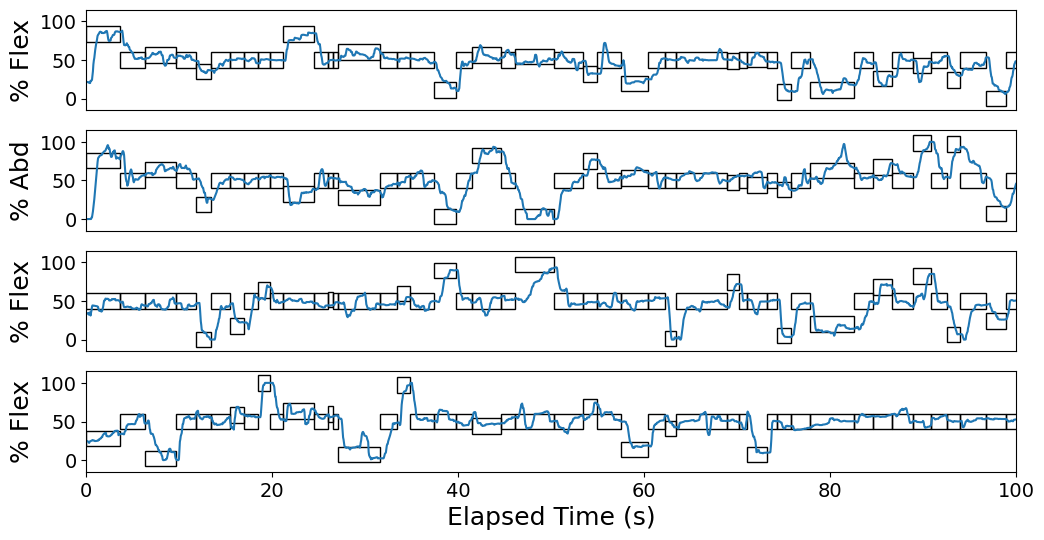

In [44]:

fn = '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153321_(45).mat'
direct_name = OUTPUT_FIG_DIR
file_name = 'TargetTraj_4DOF_20230413_block45'

PlotTargetTrajectories(fn,FingSel=[0,1,2,5],fig_fn=direct_name+file_name,plot2D=False)

C:\Users\calla\AppData\Local\Temp\ipykernel_37628\3780306270.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Target_Size = 2*float(inData['fn_hold_threshold'])


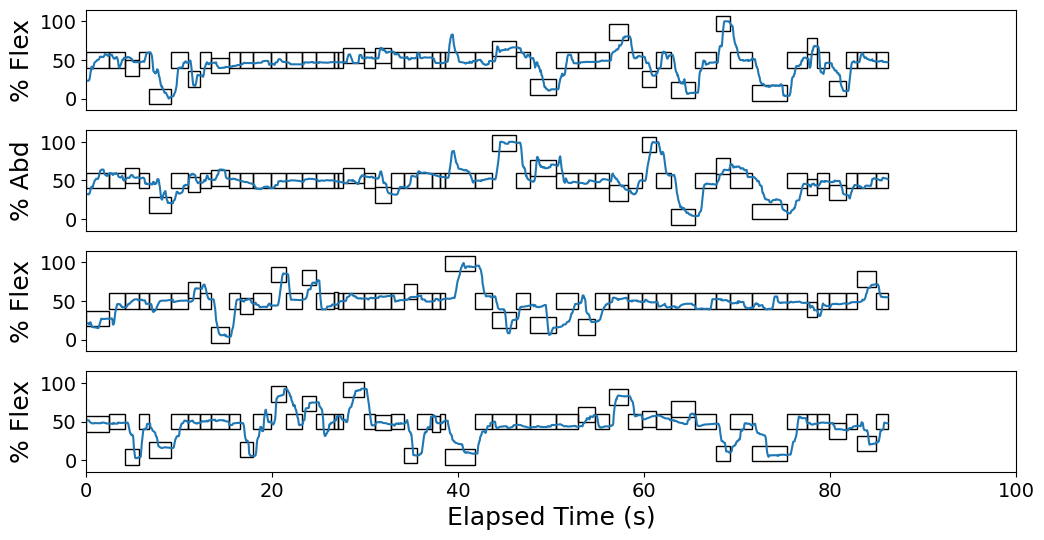

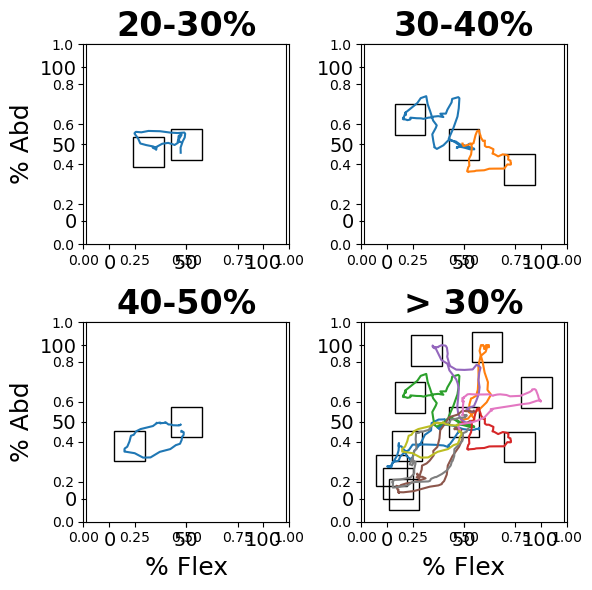

In [45]:

fn = '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154300_(48).mat'

direct_name = OUTPUT_FIG_DIR
file_name = 'TargetTraj_4DOF_20230413_block45'

PlotTargetTrajectories(fn,FingSel=[0,1,2,5],fig_fn=direct_name+file_name,plot2D=True)

In [46]:
def CalculateTrialStats(files_list, plotfig=True, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, maxTrials=0, fig_fn='SummaryStatistics', labels=[], YLIM = 12000, colors=[],returnRate=False,NumNewTargets=2,plot_dist=False, returnMetrics=False, FingConfPlot=False):
    
    AcqTimes_array = np.array([])
    ATBR_array = np.array([])
    Rate_array = np.array([])
    t2t_array = np.array([])
    OT_array = np.array([])
    Day_array = np.array([])
    BR_array = np.array([])
    TargSave = np.array([]).reshape(len(FingSel),-1)
    MoveSave = np.array([]).reshape(len(FingSel),-1)
    if len(FingSel)==2:
        dist_array = np.array([]).reshape(-1,len(FingSel))
    elif len(FingSel)==4:
        dist_array = np.array([]).reshape(-1,len(FingSel)-1)
    path_length_array = np.array([])
    Success_Numb_Sum = 0
    Total_Numb_Sum = 0
    trialNumbSucc_array = np.array([])
    TimeoutTime = 10000
    
    for k in range(len(files_list)):
        
        if hasattr(NumNewTargets, "__len__"):
            NumNewTarg_k = NumNewTargets[k]
        else:
            NumNewTarg_k = NumNewTargets

        filename = files_list[k]
        
        if len(labels)>0:
            if labels[k]=='4D/2T':
                FingSel = [0, 2]
            elif labels[k]=='2D/2T':
                FingSel = [0, 2]
            elif labels[k]=='4D/4T':
                FingSel=[0, 1, 2, 5]
        
        inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial = LoadData(filename, filepath, FingSel=FingSel, numFings=numFings, dt=dt)
        
        # Bin Time
        dt = stats.mode(np.diff(inData['binnedNeural_xpcClock'][0,:])).mode[0]
        idx = np.array(range(len(binTarg)))

        # Hold Time
        HT = float(inData['holdTime'])*1e3 # hold time in ms

        # Target Size
        Target_Size = 2*float(inData['fn_hold_threshold'])

        # Nonzero when the target has changed position
        TranLog = np.append(np.zeros([1]), np.sum(np.abs(np.diff(binTarg,axis=0)),1),axis=0)

        # Start time of each trial and start index
        BegTargTime = np.append(binNeuralTime[:1],binNeuralTime[TranLog != 0],axis=0)
        BegTargTime_idx = np.append(np.array([0]),idx[TranLog != 0])

        # End time of each trial and last index
        EndTargTime = np.append(BegTargTime[1:]-dt,binNeuralTime[-1:],axis=0)
        EndTargTime_idx = np.append(BegTargTime_idx[1:]-1,[binTarg.shape[0]-1],axis=0)

        # Set of All targets
        AllTargs = binTarg[BegTargTime_idx,:]
        EndFingPos = binPos[EndTargTime_idx,:][:,FingSel]
        BegFingPos = binPos[BegTargTime_idx,:][:,FingSel]
        
        newTargs = np.abs(np.diff(AllTargs,axis=0))>0.001
        newTargs = np.append(np.ones([1,newTargs.shape[1]]),newTargs.astype(int),axis=0)
        
        # Path Efficiency:
        path_length_k = np.array([])
        for m1 in range(BegTargTime_idx.shape[0]):
            onTargs_k = np.all(np.abs(binPos[BegTargTime_idx[m1]:EndTargTime_idx[m1],:][:,FingSel]-AllTargs[m1])<Target_Size/2,axis=1)
            
            indTemp = np.argwhere(onTargs_k==True)
            if indTemp.shape[0]<1:
                dist_k = 999999999999
                ToTarg_k = 0
                    
            else:
                OnTarg_ind = indTemp[0][0]
                idx_trial = np.array(range(BegTargTime_idx[m1],BegTargTime_idx[m1]+OnTarg_ind+1))
                dist_k = np.sum(np.sqrt(np.sum(np.square(np.diff(binPos[idx_trial,:][:,FingSel],axis=0)),axis=1)))
                ToTarg_k = np.sqrt(np.sum(np.square(binPos[idx_trial[-1:],:][:,FingSel]-BegFingPos[m1,:])))
                if dist_k == 0:
                    ToTarg_k = 1
                    dist_k = 1
            
            path_length_k = np.append(path_length_k, ToTarg_k/dist_k)

        Trial_Success = [np.all(np.abs(AllTargs[k,:]-binPos[EndTargTime_idx[k]-int(HT/dt)+1:EndTargTime_idx[k]+1,FingSel])<Target_Size/2) for k in range(AllTargs.shape[0])]
        
        # Calculate the aquisition time; since the redis and binneuraltime clocks get off by about 1-2 ms over the 50ms bins, I make sure i round to the nearest 50ms bin
        AcqTimes = dt*np.round((EndTargTime-BegTargTime)/dt)-HT+dt  # in ms

        # Not all the data from the last trial is recorded, first trial not fair with starting
        indAnalysis = np.array(range(1,len(AcqTimes)-1))
        indNZ = np.where(AcqTimes!=0)
        indAnalysis = np.intersect1d(indAnalysis,indNZ)
        
        if maxTrials > 0:
            indStopValue = np.min(np.array([indAnalysis.shape[0],maxTrials]))
            indAnalysis = indAnalysis[0:maxTrials]
        
        t2t_run = np.array([])
        for k1 in range(AcqTimes.shape[0]):
            k_ind = k1
            test = np.abs(binPos[BegTargTime_idx[k_ind]:EndTargTime_idx[k_ind],:][:,FingSel]-AllTargs[k_ind])<Target_Size/2
            t2t = 0
            for k2 in range(len(FingSel)):
                indTemp = np.argwhere(test[:,k2]==True)
                if indTemp.shape[0]<1:
                    t2t = np.round(AcqTimes[k_ind]/dt).astype(int)
                    
                else:
                    t2t = np.max(np.array([indTemp[0][0],t2t]))
            t2t_run = np.append(t2t_run,[t2t],axis=0)
            
        t2t_run *= dt
        OT_run = AcqTimes-t2t_run
    
        # Count Successes
        TrialOutcomeNumericRaw = np.zeros(len(Trial_Success))
        TrialOutcomeNumericRaw[Trial_Success] = 1
        TrialOutcomeNumeric = TrialOutcomeNumericRaw[indAnalysis].astype(int)
        
        # Calculate the power in the GT for each finger and target
        GT = 500
        DT = 200
        TargArray = np.array([]).reshape(len(FingSel),-1)
        MoveArray = np.array([]).reshape(len(FingSel),-1)
        zeroArray = np.zeros([len(FingSel),1])
        nanArray = zeroArray+float("NaN")
        TargArray = np.append(TargArray,nanArray,axis=1)
        MoveArray = np.append(MoveArray,nanArray,axis=1)
        indAnalysisPlus = np.array([])
        for k1 in range(1,AcqTimes.shape[0]):
            
            if DT+HT>=AcqTimes[k1] or np.logical_not(TrialOutcomeNumericRaw[k1]):
                TargArray = np.append(TargArray,nanArray,axis=1)
                MoveArray = np.append(MoveArray,nanArray,axis=1)
                continue
            
            FingMov = (np.abs(AllTargs[k1]-AllTargs[k1-1])>0).astype(bool)
            outTarg = np.all(np.abs(binPos[BegTargTime_idx[k1]+int(DT/dt):BegTargTime_idx[k1]+int((DT+GT)/dt),:][:,np.array(FingSel)[FingMov]]-binTarg[k1,FingMov])>Target_Size/2,axis=1)
            indFalse = np.argwhere(outTarg==False)
                
            if indFalse.size == 0:
                idxStop = 10
            else:
                idxStop = indFalse[0]
                
            if idxStop==0:
                TargArray = np.append(TargArray,nanArray,axis=1)
                MoveArray = np.append(MoveArray,nanArray,axis=1)
                continue
            
            dummyArray = zeroArray.copy()
            dummyArray[FingMov]=1
            TargArray = np.append(TargArray,dummyArray,axis=1)
            
            # Find max ind
            meanMovPower = np.abs(np.mean(binVel[BegTargTime_idx[k1]+int(DT/dt):BegTargTime_idx[k1]+int((DT+idxStop*dt)/dt),:][:,FingSel],axis=0)).reshape(-1,1)
            MoveArray = np.append(MoveArray,meanMovPower,axis=1)
            
            indAnalysisPlus = np.append(indAnalysisPlus,k1)

        
        indAnalysisPlus = np.intersect1d(indAnalysis,indAnalysisPlus).astype(int)
        
        if FingConfPlot:        
            TargSave = np.append(TargSave,TargArray[:,indAnalysisPlus],axis=1)
            MoveSave = np.append(MoveSave,MoveArray[:,indAnalysisPlus],axis=1)
        
        # Bit rate
        dist = np.abs(binTarg[BegTargTime_idx,:]-binPos[BegTargTime_idx,:][:,FingSel])
        if len(FingSel) > 2:    
            newTargs = np.sum(newTargs[:,1:],axis=1).astype(int)
            dist_thumb = np.sqrt(np.sum(dist[:,0:2]**2,axis=1))
            distHi_thumb = np.all(dist[:,0:2]>2*Target_Size/2,axis=1).reshape(-1,1)
            dist = np.append(dist_thumb.reshape(-1,1),dist[:,2:],axis=1)
            distHi = np.sum(np.append(distHi_thumb,dist[:,1:]>2*Target_Size/2,axis=1),axis=1) 
            indIncBR = distHi==newTargs
            numerator = np.log2(1+(dist-Target_Size/2)/(Target_Size))
            numerator[numerator<0] = 0
            numerator = (np.log2(3)+np.sum(numerator,axis=1))
            
        elif len(FingSel) == 2:
            newTargs = np.sum(newTargs,axis=1).astype(int)
            distHi = np.sum(dist>2*Target_Size/2,axis=1)
            indIncBR = distHi==newTargs
            numerator = np.log2(1+(dist-Target_Size/2)/(Target_Size))
            numerator[numerator<0] = 0
            numerator = np.sum(numerator,axis=1)
            
        numerator_orig = numerator.copy()
        numerator = numerator*np.array(Trial_Success).astype(int)
        denominator = (AcqTimes/1e3)
        
        BitRate = numerator[indAnalysis]/denominator[indAnalysis]
        BitRate = BitRate[indIncBR[indAnalysis]]
        indBRSuccess = np.array(Trial_Success)[indAnalysis][indIncBR[indAnalysis]]
        ATBR_array = np.append(ATBR_array,AcqTimes[indAnalysis][indIncBR[indAnalysis]][indBRSuccess])
    
        Success_Numb = np.sum(TrialOutcomeNumeric)
        Total_Numb = TrialOutcomeNumeric.shape[0]
        
        AcqTimes_array = np.append(AcqTimes_array,AcqTimes[indAnalysis[TrialOutcomeNumeric.astype(bool)]],axis=0)
        Rate_array = np.append(Rate_array,1000*60*NumNewTarg_k/np.mean(AcqTimes[indAnalysis[TrialOutcomeNumeric.astype(bool)]]))
        path_length_array = np.append(path_length_array,path_length_k[indAnalysis[TrialOutcomeNumeric.astype(bool)]],axis=0)
        t2t_array = np.append(t2t_array,t2t_run[indAnalysis[TrialOutcomeNumeric.astype(bool)]],axis=0)
        OT_array = np.append(OT_array,OT_run[indAnalysis[TrialOutcomeNumeric.astype(bool)]],axis=0)
        Success_Numb_Sum = Success_Numb_Sum + Success_Numb
        Total_Numb_Sum += Total_Numb
        BR_array = np.append(BR_array,BitRate)
        if plot_dist:
            dist_array = np.append(dist_array,dist[indAnalysis[TrialOutcomeNumeric.astype(bool)],:],axis=0)
        
        Day_array = np.append(Day_array,(k+1)*np.ones_like(AcqTimes[indAnalysis[TrialOutcomeNumeric.astype(bool)]]))
        trialNumbSucc_array = np.append(trialNumbSucc_array,Success_Numb)

    Times_mean = np.mean(AcqTimes_array)
    Times_SEM = (np.std(AcqTimes_array)/np.sqrt(AcqTimes_array.shape[0]))
    Times_median = np.median(AcqTimes_array)
    
    RatePR_mean = np.mean(Rate_array)
    RatePR_SEM = np.std(Rate_array)/np.sqrt(Rate_array.shape[0])
    
    BR_mean = np.mean(BR_array)
    BR_SEM = np.std(BR_array)/np.sqrt(BR_array.shape[0])
    ATBR_mean = np.mean(ATBR_array)
    ATBR_SEM = np.std(ATBR_array)/np.sqrt(ATBR_array.shape[0])
    
    PL_mean = np.mean(path_length_array)
    PL_SEM = (np.std(path_length_array)/np.sqrt(path_length_array.shape[0]))
    
    t2t_mean = np.mean(t2t_array)
    t2t_SEM = (np.std(t2t_array)/np.sqrt(t2t_array.shape[0]))
    
    OT_mean = np.mean(OT_array)
    OT_SEM = (np.std(OT_array)/np.sqrt(OT_array.shape[0]))
    
    Metric_Data = dict([])
    Metric_Data['Trials'] = AcqTimes_array.shape[0]
    Metric_Data['AT_mean'] = Times_mean
    Metric_Data['AT_SEM'] = Times_SEM
    Metric_Data['T2T_mean'] = t2t_mean
    Metric_Data['T2T_SEM'] = t2t_SEM
    Metric_Data['OT_mean'] = OT_mean
    Metric_Data['OT_SEM'] = OT_SEM
    Metric_Data['Rate_mean'] = RatePR_mean
    Metric_Data['Rate_SEM'] = RatePR_SEM
    Metric_Data['PerCorr'] = 100*Success_Numb_Sum/Total_Numb_Sum
    Metric_Data['PL_mean'] = PL_mean
    Metric_Data['PL_SEM'] = PL_SEM
    
    print("Number of trials: %s" %AcqTimes_array.shape[0])
    print("Number of runs: %s" %len(files_list))
    print('Mean (+/- SEM) Acquistion Time: %s +/- %s ms' %(Times_mean, Times_SEM))
    print('Mean (+/- SEM) Time to Target: %s +/- %s ms' %(t2t_mean, t2t_SEM))
    print('Mean (+/- SEM) Orbiting Time: %s +/- %s ms' %(OT_mean, OT_SEM))
    print('Mean (+/- SEM) Throughput: %s +/- %s bps' %(BR_mean, BR_SEM))
    print('Mean (+/- SEM) Acq Time of High Bit Samples: %s +/- %s ms' %(ATBR_mean, ATBR_SEM))
    print('Number of samples for throughput: %s' %(BR_array.shape[0]))
    print('Median (+/- SEM) Acquistion Time: %s ms' %(Times_median))
    print('Mean (+/- SEM) Targets per Min (Averaged on a per Run): %s +/- %s' %(RatePR_mean, RatePR_SEM))
    print('Percent correct trials: %s percent' %(100*Success_Numb_Sum/Total_Numb_Sum))
    print('Mean Path Length (+/- SEM): %s +/- %s' %(PL_mean, PL_SEM))
    
    Day_array = Day_array.astype(int)
    trialNumbSucc_array = trialNumbSucc_array.astype(int)
    
    if FingConfPlot:
        uniqueFingerMov = np.unique(TargSave,axis=1)
        avgMeanVal = np.array([]).reshape(len(FingSel),-1)
        for k1 in range(uniqueFingerMov.shape[1]):
            indVal = np.array([]).astype(int)
            for k2 in range(TargSave.shape[1]):
                if np.all(TargSave[:,k2:k2+1]==uniqueFingerMov[:,k1:k1+1]):
                    indVal = np.append(indVal,k2)
            avgMeanVal = np.append(avgMeanVal,np.mean(MoveSave[:,indVal],axis=1).reshape(len(FingSel),-1),axis=1)

        if np.any(0==np.array(FingSel)) and np.any(1==np.array(FingSel)):
            if len(FingSel)>2:
                avgMeanVal = np.append(np.mean(avgMeanVal[0:2,:],axis=0,keepdims=True),avgMeanVal[2:,:],axis=0)
            else:
                avgMeanVal = np.mean(avgMeanVal[0:2,:],axis=0,keepdims=True)

        avgMeanVal = avgMeanVal/np.max(avgMeanVal,axis=0).reshape(1,-1)
    
    if plotfig:
        fig = plt.figure(facecolor='white')
        fig.set_size_inches(3/4*len(files_list), 6, forward=True)
        
        for rn_k in enumerate(np.unique(Day_array)):
            ind_k = rn_k[0]
            run_k = rn_k[1]
            ind_plot = np.where(run_k==Day_array)[0]
            adj_array = np.linspace(-.1, .1, num=ind_plot.shape[0])
            
            color_k = 'b'
            if len(colors) >= run_k:
                color_k = colors[ind_k]
            
            plt.plot(Day_array[ind_plot]-adj_array,AcqTimes_array[ind_plot],'o',color=color_k,markersize=4)
            plt.plot(run_k,np.mean(AcqTimes_array[ind_plot]),'D',color='k',markersize=5)
            
        plt.xlabel('Run Number',fontsize=14)
        plt.ylabel('Target Acquisition Times (ms)',fontsize=14)
        plt.xlim(0.5,len(files_list)+0.5)
        plt.ylim(0,YLIM)

        xticks = np.unique(Day_array)
        plt.xticks(xticks,xticks,fontsize=12)
        if len(labels)>0:
            ax = plt.gca()
            ax.set_xticklabels(labels)
            
        plt.yticks(int(np.round(2/12*YLIM))*np.array(range(0,6),dtype=int),int(np.round(2/12*YLIM))*np.array(range(0,6),dtype=int))
        
        for kk in range(xticks.shape[0]):
            ind_temp = np.argwhere(Day_array==xticks[kk])
            ind_k = np.where(np.unique(Day_array)==xticks[kk])[0][0]
            plt.text(xticks[kk]-.3, 10.5/12*YLIM*np.ones_like(xticks)[kk], '$N=$'+str(trialNumbSucc_array[kk]), fontsize = 9.5, color='k')
            plt.text(xticks[kk]-.3, 11/12*YLIM*np.ones_like(xticks)[kk], '$R=$'+str(round(Rate_array[ind_k])), fontsize = 9.5, color='k')
            plt.text(xticks[kk]-.3, 11.5/12*YLIM*np.ones_like(xticks)[kk], '$\mu=$'+str(round(np.mean(AcqTimes_array[ind_temp])/1e3,1)), fontsize = 9.5, color='k')

        plt.savefig(fig_fn+'.pdf',dpi=900,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='pdf')
        plt.savefig(fig_fn+'.jpg',dpi=300,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='jpg')
        
        print('The plot shows %s percent of data' %(100-100*np.where(AcqTimes_array>YLIM)[0].shape[0]/AcqTimes_array.shape[0]))
        
        
        if plot_dist:
            fig2 = plt.figure()
            nBins = 20

            if len(FingSel)==2:
                dist_hist = np.concatenate((dist_array[:,0],dist_array[:,1]),axis=0)
                labels = ['IM and RS Fingers']
            elif len(FingSel)==4:
                dist_hist = np.concatenate((dist_array[:,1],dist_array[:,2]),axis=0)
                dist_Th = dist_array[:,0]
                labels = ['IM and RS','Thumb']

            hist_fing, bins_fing = np.histogram(dist_hist,bins=nBins)
            bins =(bins_fing[1:]+bins_fing[0:-1])/2
            diff_bins = bins[1]-bins[0]
            bins = np.concatenate(([-2],[bins[0]-diff_bins],bins,[bins[-1]+diff_bins],[2]))
            hist_fing = np.concatenate((np.zeros(2),hist_fing,np.zeros(2)))
            hist_fing = hist_fing/np.sum(hist_fing)/diff_bins
            plt.plot(bins,hist_fing,color='g',label=labels[0],marker='.')
            if len(FingSel)==4:
                hist_th, bins_th = np.histogram(dist_Th,bins=nBins)
                bins =(bins_th[1:]+bins_th[0:-1])/2
                diff_bins = bins[1]-bins[0]
                bins = np.concatenate(([-2],[bins[0]-diff_bins],bins,[bins[-1]+diff_bins],[2]))
                hist_th = np.concatenate((np.zeros(2),hist_th,np.zeros(2)))
                hist_th = hist_th/np.sum(hist_th)/diff_bins
                plt.plot(bins,hist_th,color='r',label=labels[1],marker='.')

            plt.title('Distribution of Trial Distances')
            plt.ylabel('Estimated PDF')
            plt.xlabel('Distance (a.u.)')
            plt.xlim([-.025,0.725])
            plt.legend(loc="upper right")

            plt.savefig(fig_fn+'_dist'+'.pdf',dpi=900,facecolor=fig2.get_facecolor(),bbox_inches = "tight", format='pdf')
            plt.savefig(fig_fn+'_dist'+'.jpg',dpi=300,facecolor=fig2.get_facecolor(),bbox_inches = "tight", format='jpg')
            
        if FingConfPlot:
            fig3 = plt.figure()
            axCM = plt.gca()
            plt.imshow(avgMeanVal, extent=[0.5, avgMeanVal.shape[1]+0.5, +0.5, avgMeanVal.shape[0]+0.5],vmin=0, vmax=1,cmap='jet')
            plt.xticks(np.array(range(1,avgMeanVal.shape[1]+1)),np.array(range(1,avgMeanVal.shape[1]+1)),fontsize=12)
            plt.yticks(np.array(range(1,avgMeanVal.shape[0]+1)),np.array(range(1,avgMeanVal.shape[0]+1)),fontsize=12)
            plt.colorbar()
            plt.gca().invert_yaxis()
            
            plt.savefig(fig_fn+'_ConfFing'+'.pdf',dpi=900,facecolor=fig3.get_facecolor(),bbox_inches = "tight", format='pdf')
            plt.savefig(fig_fn+'_ConfFing'+'.jpg',dpi=300,facecolor=fig3.get_facecolor(),bbox_inches = "tight", format='jpg')

    if returnRate:
        return AcqTimes_array, Rate_array
    elif returnMetrics:
        return AcqTimes_array, Rate_array, Metric_Data
    else:
        return AcqTimes_array

<>:326: SyntaxWarning: invalid escape sequence '\m'
<>:326: SyntaxWarning: invalid escape sequence '\m'
C:\Users\calla\AppData\Local\Temp\ipykernel_37628\1733632129.py:326: SyntaxWarning: invalid escape sequence '\m'
  plt.text(xticks[kk]-.3, 11.5/12*YLIM*np.ones_like(xticks)[kk], '$\mu=$'+str(round(np.mean(AcqTimes_array[ind_temp])/1e3,1)), fontsize = 9.5, color='k')


Number of trials: 178
Number of runs: 4
Mean (+/- SEM) Acquistion Time: 1373.0337078651685 +/- 66.33153509144198 ms
Mean (+/- SEM) Time to Target: 889.0449438202247 +/- 46.50760426154807 ms
Mean (+/- SEM) Orbiting Time: 483.9887640449438 +/- 55.74037943498293 ms
Mean (+/- SEM) Throughput: 2.5362658072451403 +/- 0.1371271647030122 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1525.0 +/- 87.37255231985068 ms
Number of samples for throughput: 102
Median (+/- SEM) Acquistion Time: 1175.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 44.808146769244836 +/- 3.7115037242477564
Percent correct trials: 100.0 percent
Mean Path Length (+/- SEM): 0.6740594467601482 +/- 0.014116160022076529
The plot shows 100.0 percent of data


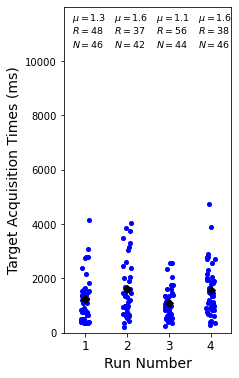

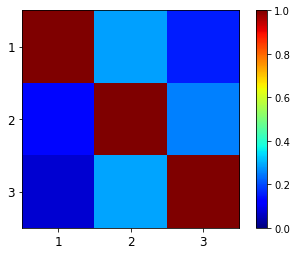

In [11]:
files_list_1 = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153016_(44).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153616_(46).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155107_(50).mat']
direct_name = OUTPUT_FIG_DIR
file_name = '1FingPlots'
AcqTimes_1Fing, Rate_1Fing = CalculateTrialStats(files_list_1,FingSel=[0, 1, 2, 5], fig_fn=direct_name+file_name, numFings=6, plotfig=True, returnRate=True, NumNewTargets=1, FingConfPlot=True)

Number of trials: 529
Number of runs: 7
Mean (+/- SEM) Acquistion Time: 1327.2211720226844 +/- 30.143258252986822 ms
Mean (+/- SEM) Time to Target: 1107.65595463138 +/- 25.8047177894382 ms
Mean (+/- SEM) Orbiting Time: 219.56521739130434 +/- 21.844079701952097 ms
Mean (+/- SEM) Throughput: 1.5817796300600984 +/- 0.04828238763332206 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1597.7011494252874 +/- 57.148253327307145 ms
Number of samples for throughput: 180
Median (+/- SEM) Acquistion Time: 1200.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 88.41060730620441 +/- 6.029151331073392
Percent correct trials: 98.14471243042672 percent
Mean Path Length (+/- SEM): 0.718494345768899 +/- 0.007269832512943367
The plot shows 100.0 percent of data


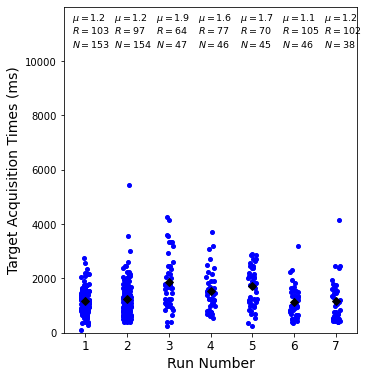

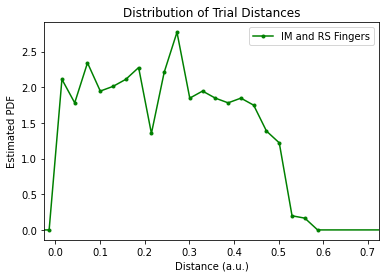

In [12]:
# Population data for 2 finger data
files_list = ['20230321/RedisMat/t5_t5.2023.03.21_Data_RedisMat_20230321_162754_(18).mat',
              '20230321/RedisMat/t5_t5.2023.03.21_Data_RedisMat_20230321_163420_(19).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_135514_(7).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140002_(8).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140335_(9).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_144356_(15).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_144851_(16).mat']

direct_name = OUTPUT_FIG_DIR
file_name = 'PopData_2DOF'
    
AcqTimes_2DOF, _, Metrics_2DOF = CalculateTrialStats(files_list,FingSel=[0, 2],fig_fn=direct_name+file_name,plot_dist=True,returnMetrics=True)

Number of trials: 524
Number of runs: 9
Mean (+/- SEM) Acquistion Time: 1984.7328244274809 +/- 51.680850279964865 ms
Mean (+/- SEM) Time to Target: 1384.5419847328244 +/- 30.735844608553034 ms
Mean (+/- SEM) Orbiting Time: 600.1908396946565 +/- 40.330888278609 ms
Mean (+/- SEM) Throughput: 2.1775356671468273 +/- 0.08682940294944747 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 2143.939393939394 +/- 90.62776911166355 ms
Number of samples for throughput: 138
Median (+/- SEM) Acquistion Time: 1650.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 64.31231641513018 +/- 4.040802089428903
Percent correct trials: 98.68173258003766 percent
Mean Path Length (+/- SEM): 0.5240702213324575 +/- 0.006953017789213823
The plot shows 100.0 percent of data


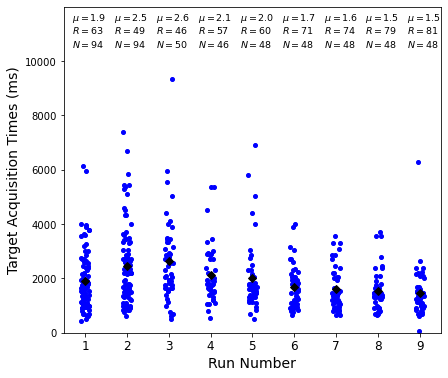

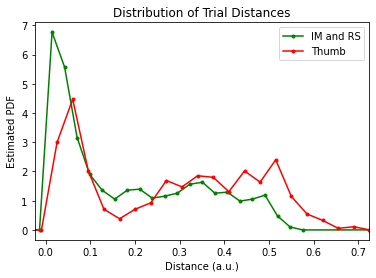

In [13]:
# First 100 after training

files_list = ['20230309/RedisMat/t5_t5.2023.03.09_Data_RedisMat_20230309_150822_(18).mat',
              '20230314/RedisMat/t5_t5.2023.03.14_Data_RedisMat_20230314_155042_(17).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_144512_(14).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145004_(15).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152402_(24).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152739_(25).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_131021_(7).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_131337_(8).mat']

direct_name = OUTPUT_FIG_DIR
file_name = 'PopData_4DOF'
    
AcqTimes_4DOF, _, Metrics_4DOF = CalculateTrialStats(files_list, maxTrials=100,fig_fn=direct_name+file_name,plot_dist=True,returnMetrics=True,FingConfPlot=False)

In [14]:
def plotBarStats(Data,labels,colors,fig_fn='SummaryStatistics'):
    
    ns=6
    lw=2.5
    
    NUM_SIZE = 12+4
    LABEL_SIZE = 24


    plt.rc('axes', titlesize=LABEL_SIZE)     # fontsize of the axes title
    plt.rc('xtick', labelsize=NUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=NUM_SIZE)    # fontsize of the tick labels
    plt.rc('figure', titlesize=LABEL_SIZE)  # fontsize of the figure title
    
    fig, ax = plt.subplots(nrows=1, ncols=ns, figsize=(12, 6))
    ax = plt.subplot(1,ns,1)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['AT_mean']/1e3,yerr=Data[k]['AT_SEM']/1e3,error_kw=dict(lw=lw, capsize=5, capthick=3),color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('Acq Time\n(s)',fontweight='bold')
    axes = plt.gca()
    Ymax = axes.get_ylim()
    
    ax = plt.subplot(1,ns,2)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['T2T_mean']/1e3,yerr=Data[k]['T2T_SEM']/1e3,error_kw=dict(lw=lw, capsize=5, capthick=3),color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('T2T\n(s)',fontweight='bold')
    plt.ylim(Ymax)
    
    ax = plt.subplot(1,ns,3)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['OT_mean']/1e3,yerr=Data[k]['OT_SEM']/1e3,error_kw=dict(lw=lw, capsize=5, capthick=3),color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('Orb\n(s)',fontweight='bold')
    plt.ylim(Ymax)
    
    ax = plt.subplot(1,ns,4)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['Rate_mean'],yerr=Data[k]['Rate_SEM'],error_kw=dict(lw=lw, capsize=5, capthick=3),color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('Rate\n(targ/min)',fontweight='bold')
    
    ax = plt.subplot(1,ns,5)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['PL_mean'],yerr=Data[k]['PL_SEM'],error_kw=dict(lw=lw, capsize=5, capthick=3),color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('Path Len\nEff',fontweight='bold')
    
    ax = plt.subplot(1,ns,6)
    for k in range(len(Data)):
        plt.bar(k,Data[k]['PerCorr'],color=colors[k])
    plt.xticks(np.array(range(len(Data))),labels)
    plt.title('Percent\nComplete',fontweight='bold')
    
    fig.tight_layout()
    
    plt.savefig(fig_fn+'.pdf',dpi=900,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='pdf')
    plt.savefig(fig_fn+'.jpg',dpi=300,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='jpg')
    
    return

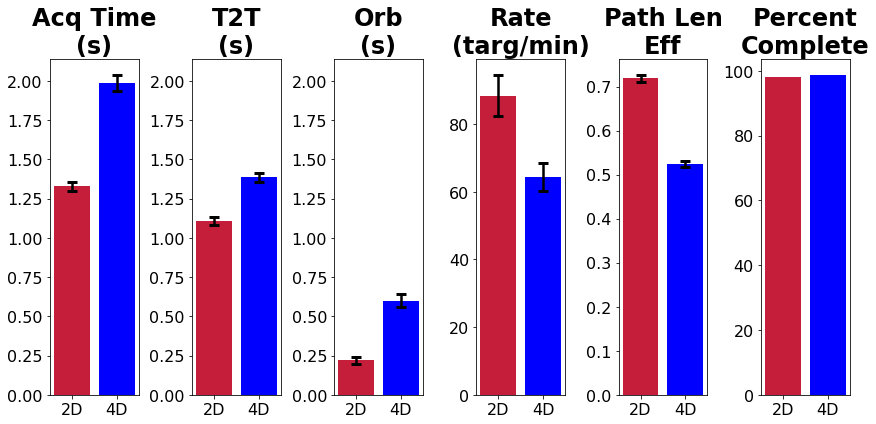

In [15]:
direct_name = OUTPUT_FIG_DIR
file_name = 'Metrics_2Dvs4D'

Data = [Metrics_2DOF,Metrics_4DOF]
plotBarStats([Metrics_2DOF,Metrics_4DOF],['2D','4D'],['#c41e3a','b'],fig_fn=direct_name+file_name)

Number of trials: 192
Number of runs: 4
Mean (+/- SEM) Acquistion Time: 1575.78125 +/- 57.252563078623155 ms
Mean (+/- SEM) Time to Target: 1196.09375 +/- 37.99034533631202 ms
Mean (+/- SEM) Orbiting Time: 379.6875 +/- 48.46151433438736 ms
Mean (+/- SEM) Throughput: 2.6010920230950254 +/- 0.12104348230344504 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1742.5925925925926 +/- 81.2011951912828 ms
Number of samples for throughput: 54
Median (+/- SEM) Acquistion Time: 1400.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 76.36862505552348 +/- 2.0202400758948897
Percent correct trials: 100.0 percent
Mean Path Length (+/- SEM): 0.5797671392501756 +/- 0.010187546855273713
The plot shows 100.0 percent of data


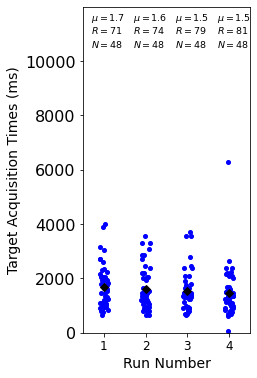

In [16]:

files_list = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152739_(25).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_131021_(7).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_131337_(8).mat']

AcqTimes = CalculateTrialStats(files_list, maxTrials=100)

Day 1
Number of trials: 225
Number of runs: 5
Mean (+/- SEM) Acquistion Time: 2764.0 +/- 113.92121167340085 ms
Mean (+/- SEM) Time to Target: 1615.5555555555557 +/- 57.35926296607178 ms
Mean (+/- SEM) Orbiting Time: 1148.4444444444443 +/- 100.61607318820111 ms
Mean (+/- SEM) Throughput: 1.6076029111205303 +/- 0.11687145820982246 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 2921.6417910447763 +/- 211.246035157561 ms
Number of samples for throughput: 75
Median (+/- SEM) Acquistion Time: 2250.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 44.78558298558057 +/- 4.321378612451676
Percent correct trials: 93.3609958506224 percent
Mean Path Length (+/- SEM): 0.43041252445887396 +/- 0.011147861418307571
 
Day 1 after Retraining
Number of trials: 94
Number of runs: 2
Mean (+/- SEM) Acquistion Time: 1938.8297872340424 +/- 128.18631192713843 ms
Mean (+/- SEM) Time to Target: 1143.0851063829787 +/- 52.762102337668885 ms
Mean (+/- SEM) Orbiting Time: 795.7446808510638 +/- 109.53485

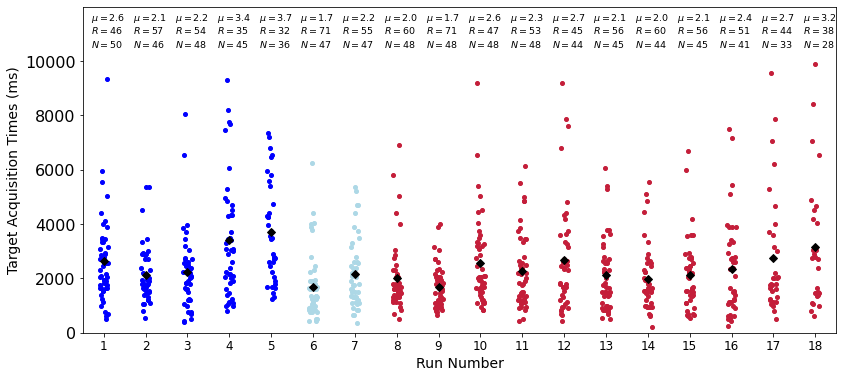

In [17]:
c1 = 'b'
c2 = '#ADD8E6'
c3 = '#c41e3a'

# Long Run 1
print('Day 1')
files_list_day1 = ['20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_144512_(14).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145004_(15).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145406_(16).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_150013_(17).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_150705_(18).mat']
AcqTimes = CalculateTrialStats(files_list_day1,plotfig=False)
colors = [c1,c1,c1,c1,c1]
print(' ')



# Long Run 1 after retraining
print('Day 1 after Retraining')
files_list_day1RT = ['20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_155613_(26).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_155923_(27).mat']
AcqTimes = CalculateTrialStats(files_list_day1RT,plotfig=False)
colors = colors+[c2,c2]
print(' ')

# Long Run 2
print('Day 2')
files_list_day2 = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152402_(24).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152739_(25).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153159_(26).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153613_(27).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154046_(28).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154505_(29).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155009_(30).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155427_(31).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_160003_(32).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_160635_(33).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_161456_(34).mat']
AcqTimes = CalculateTrialStats(files_list_day2,plotfig=False)
colors = colors+[c3,c3,c3,c3,c3,c3,c3,c3,c3,c3,c3]
print(' ')

direct_name = OUTPUT_FIG_DIR
file_name = 'Supp2_Stability'

print('Both Days Plus Retraining')
AcqTimes = CalculateTrialStats(files_list_day1+files_list_day1RT+files_list_day2,colors=colors,fig_fn=direct_name+file_name)

In [18]:
perChange = 100*(np.mean(AcqTimes_4DOF)-np.mean(AcqTimes_2DOF))/np.mean(AcqTimes_2DOF)
myRes = stats.ttest_ind(AcqTimes_4DOF, AcqTimes_2DOF, alternative='two-sided')
p_value = myRes[1]

print('Percent increase in 4D over 2D acquistion time: %s' %round(perChange,2))
print('P-value: %s' %p_value)

statsMatlab = dict([])
statsMatlab['AcqTimes_4DOF'] = AcqTimes_4DOF
statsMatlab['AcqTimes_2DOF']= AcqTimes_2DOF

Percent increase in 4D over 2D acquistion time: 49.54
P-value: 9.777840223423794e-27


Number of trials: 846
Number of runs: 18
Mean (+/- SEM) Acquistion Time: 1354.9645390070923 +/- 31.49999884533808 ms
Mean (+/- SEM) Time to Target: 1105.3782505910165 +/- 21.432904592207276 ms
Mean (+/- SEM) Orbiting Time: 249.58628841607566 +/- 20.71670590219111 ms
Mean (+/- SEM) Throughput: 1.9880009497755338 +/- 0.05222967806276136 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1652.1317829457364 +/- 61.895636035357434 ms
Number of samples for throughput: 258
Median (+/- SEM) Acquistion Time: 1150.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 93.37597398354607 +/- 4.96455037425288
Percent correct trials: 99.64664310954063 percent
Mean Path Length (+/- SEM): 0.6663921419378753 +/- 0.0063194820580129265
The plot shows 99.29078014184397 percent of data


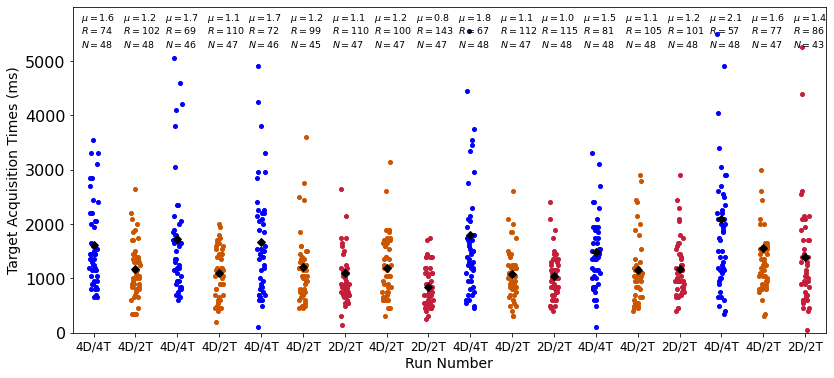

In [19]:

files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160214_(31).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160835_(33).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_161118_(34).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164304_(42).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164542_(43).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164821_(44).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165126_(45).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_135646_(19).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140127_(20).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140435_(21).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140856_(22).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141137_(23).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141525_(25).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141856_(26).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142206_(27).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142510_(28).mat']
              

labels = ['4D/4T','4D/2T','4D/4T','4D/2T','4D/4T','4D/2T','2D/2T','4D/2T','2D/2T','4D/4T','4D/2T','2D/2T','4D/4T','4D/2T','2D/2T','4D/4T','4D/2T','2D/2T']
c1 = 'b'
c2 = '#CC5500'
c3 = '#c41e3a'
colors = [     c1,     c2,      c1,    c2,     c1,    c2,     c3,      c2,    c3,     c1,     c2,      c3,    c1,     c2,     c3,    c1,     c2,     c3]

direct_name = OUTPUT_FIG_DIR
file_name = '4Dvs2D'

AcqTimes = CalculateTrialStats(files_list, labels=labels,fig_fn=direct_name+file_name,YLIM=6000,colors=colors)

In [20]:
print(' ')
print(' ')
print('4D/4T')
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160835_(33).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164304_(42).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_135646_(19).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140856_(22).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141856_(26).mat']
AcqTimes_4D4T,_,Metrics_4D4T = CalculateTrialStats(files_list, plotfig=False,returnMetrics=True)

print(' ')
print(' ')
print('4D/2T')
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160214_(31).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_161118_(34).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164542_(43).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165126_(45).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140127_(20).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141137_(23).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142206_(27).mat']
AcqTimes_4D2T,_,Metrics_4D2T = CalculateTrialStats(files_list, plotfig=False, FingSel=[0,2],returnMetrics=True)

print(' ')
print(' ')
print('2D/2T')
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164821_(44).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140435_(21).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141525_(25).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142510_(28).mat']
AcqTimes_2D2T,_,Metrics_2D2T = CalculateTrialStats(files_list, plotfig=False, FingSel=[0,2],returnMetrics=True)   

 
 
4D/4T
Number of trials: 284
Number of runs: 6
Mean (+/- SEM) Acquistion Time: 1729.7535211267605 +/- 66.15606705078856 ms
Mean (+/- SEM) Time to Target: 1205.4577464788733 +/- 36.293925990976724 ms
Mean (+/- SEM) Orbiting Time: 524.2957746478874 +/- 52.96076172713464 ms
Mean (+/- SEM) Throughput: 2.5173375905750195 +/- 0.12580008935738443 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1994.0 +/- 128.40546890395456 ms
Number of samples for throughput: 75
Median (+/- SEM) Acquistion Time: 1475.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 70.20000974220827 +/- 2.9946334626304427
Percent correct trials: 99.64912280701755 percent
Mean Path Length (+/- SEM): 0.5577922269833862 +/- 0.009967460537665123
 
 
4D/2T
Number of trials: 329
Number of runs: 7
Mean (+/- SEM) Acquistion Time: 1207.90273556231 +/- 41.06038211039599 ms
Mean (+/- SEM) Time to Target: 1062.7659574468084 +/- 34.12541248271107 ms
Mean (+/- SEM) Orbiting Time: 145.13677811550153 +/- 18.8406257447436 ms
M

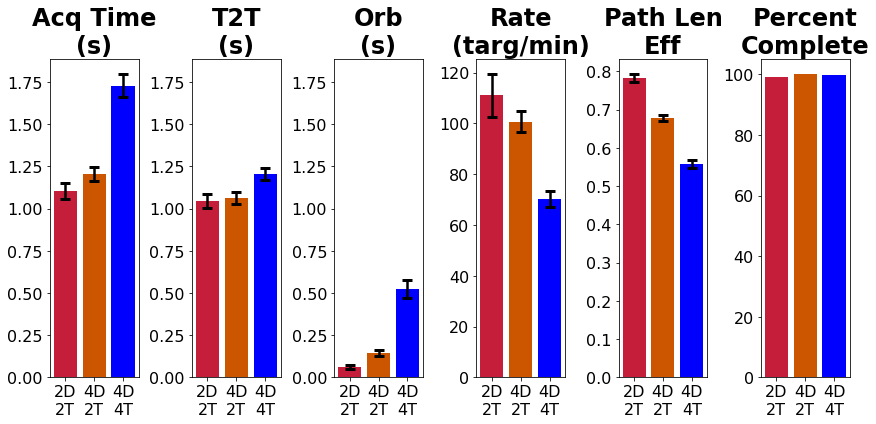

In [21]:
direct_name = OUTPUT_FIG_DIR
file_name = 'Metrics_2Dvs4D2Tvs4D4T'

c1 = 'b'
c2 = '#CC5500'
c3 = '#c41e3a'

Data = [Metrics_2D2T,Metrics_4D2T,Metrics_4D4T]
plotBarStats(Data,['2D\n2T','4D\n2T','4D\n4T'],[c3,c2,c1],fig_fn=direct_name+file_name)

In [22]:
perChange = 100*(np.mean(AcqTimes_4D2T)-np.mean(AcqTimes_2D2T))/np.mean(AcqTimes_2D2T)
p_value = stats.ttest_ind(AcqTimes_4D2T, AcqTimes_2D2T,alternative='two-sided')[1]

print('Percent increase in 4D Dec over 2D Dec acquistion time (both on 2D Task): %s' %round(perChange,2))
print('P-value: %s' %p_value)

statsMatlab['AcqTimes_4D2T'] = AcqTimes_4D2T
statsMatlab['AcqTimes_2D2T']= AcqTimes_2D2T

Percent increase in 4D Dec over 2D Dec acquistion time (both on 2D Task): 9.23
P-value: 0.10133162215433536


Movie 01:
Number of trials: 47
Number of runs: 1
Mean (+/- SEM) Acquistion Time: 840.4255319148937 +/- 54.19559286338102 ms
Mean (+/- SEM) Time to Target: 800.0 +/- 50.484300075339036 ms
Mean (+/- SEM) Orbiting Time: 40.42553191489362 +/- 18.648198688695047 ms
Mean (+/- SEM) Throughput: 1.8656345738260685 +/- 0.11615272027765033 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1305.5555555555557 +/- 91.43723626391488 ms
Number of samples for throughput: 9
Median (+/- SEM) Acquistion Time: 750.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 142.78481012658227 +/- 0.0
Percent correct trials: 100.0 percent
Mean Path Length (+/- SEM): 0.7317599809341181 +/- 0.02493543748613264
The plot shows 100.0 percent of data
 
Movie 02:
Number of trials: 48
Number of runs: 1
Mean (+/- SEM) Acquistion Time: 1478.125 +/- 92.72479079111986 ms
Mean (+/- SEM) Time to Target: 1111.4583333333333 +/- 58.98518939528537 ms
Mean (+/- SEM) Orbiting Time: 366.6666666666667 +/- 71.4333249079686 ms
Mean

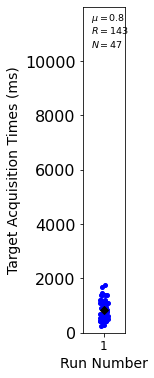

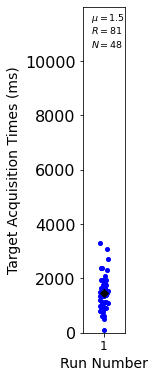

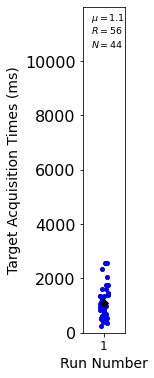

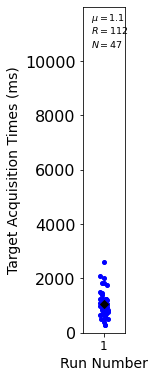

In [23]:
# Movie 1, 2DOF Exemplar
print('Movie 01:')
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat']
direct_name = OUTPUT_FIG_DIR
file_name = 'Movie_01'
AcqTimes = CalculateTrialStats(files_list,FingSel=[0, 2],fig_fn=direct_name+file_name)

print(' ')

# Movie 2, 4DOF Exemplar 1
print('Movie 02:')
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140856_(22).mat']
direct_name = OUTPUT_FIG_DIR
file_name = 'Movie_02'
AcqTimes = CalculateTrialStats(files_list,FingSel=[0, 1, 2, 5],fig_fn=direct_name+file_name)

print(' ')

# Movie 3, 4DOF, 1 new target, Exemplar
print('Movie 03:')
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat']
direct_name = OUTPUT_FIG_DIR
file_name = 'Movie_03'
AcqTimes = CalculateTrialStats(files_list,FingSel=[0, 1, 2, 5],fig_fn=direct_name+file_name,NumNewTargets=1)

print(' ')

# Movie 4, 4DOF, 2DOF Task, Exemplar
print('Movie 04:')
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140127_(20).mat']
direct_name = OUTPUT_FIG_DIR
file_name = 'Movie_04'
AcqTimes = CalculateTrialStats(files_list,FingSel=[0, 2],fig_fn=direct_name+file_name)

Estimated CC for first label: 0.6926044358744636 +/- 0.02159072417792021
Estimated CC for first label: 0.6795875815609058 +/- 0.01624366815062079


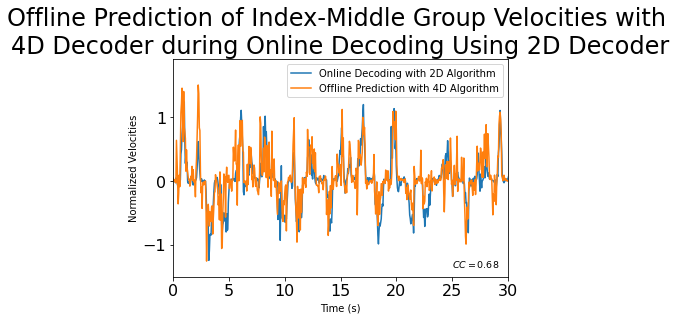

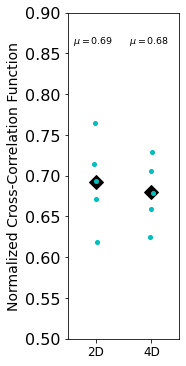

In [24]:
def myNewFunction(files_list, params_list, hyper_list, labels, plotfig=True, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, ind_ref=[0, 2], maxTrials=0, fig_fn='SummaryStatistics', YLIM = 0.9, colors=[]):

    corr_array = np.array([])
    corr_array_orth = np.array([])

    TimeoutTime = 10000

    # Define model parameters
    input_size = 256

    # NN variables
    hidden_size = 256
    ConvSizeOut = 16
    ConvSize = 3
    num_states = len(FingSel)
    layer_num = 4
    
    for k in range(len(files_list)):
        
        if labels[k] == '2D':
            FingSel_ref = [0,2]
            FingSel_pred = [0,1,2,5]
            num_states = len(FingSel_pred)
            ind_pred = [0,2]
        elif labels[k] == '4D':
            FingSel_ref = [0,1,2,5]
            FingSel_pred = [0,2]
            num_states = len(FingSel_pred)
            ind_pred = [0,1]

        # NN Model
        model = nd.FF_CN_FC_SBP_Analyze(input_size, hidden_size, layer_num, ConvSize, ConvSizeOut, num_states).to(device)
        model = model.eval()
            
        filename = files_list[k]
        in_weights = params_list[k]
        in_hyperParams = hyper_list[k]
        
        model.load_state_dict(torch.load(filepath + in_weights))
        matFile = sio.loadmat(filepath + in_hyperParams)
        myMean = matFile['myMean']
        mySDev = matFile['mySDev']
        mask = matFile['mask']

        gain = 1/mySDev
        theMed = myMean
        
        inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial = LoadData(filename, filepath, FingSel=FingSel_ref, numFings=numFings, dt=dt)
        
        Y_continuous_temp = mask * binNeural
        Y_continuous_1 = np.zeros([int(Y_continuous_temp.shape[0]), int(Y_continuous_temp.shape[1]), ConvSize])
        Y_continuous_1[:, :, 0] = Y_continuous_temp
        for m1 in range(ConvSize - 1):
            m = m1 + 1
            Y_continuous_1[m:, :, m] = Y_continuous_temp[0:-m, :]

        vh,x_nodes = model(torch.tensor(Y_continuous_1).to(device).to(dtype))
        vh = gain * (vh.detach().to('cpu').numpy() - theMed)
        
        #Finger 1

        norm_term = np.sqrt(np.max(np.correlate(binVel[:,ind_ref[0]],binVel[:,ind_ref[0]],"full"))*np.max(np.correlate(vh[:,ind_pred[0]],vh[:,ind_pred[0]],"full")))
        r1 = np.max(np.correlate(binVel[:,ind_ref[0]],vh[:,ind_pred[0]],"full"))/norm_term
        
        norm_term = np.sqrt(np.max(np.correlate(binVel[:,ind_ref[1]],binVel[:,ind_ref[1]],"full"))*np.max(np.correlate(vh[:,ind_pred[1]],vh[:,ind_pred[1]],"full")))
        r2 = np.max(np.correlate(binVel[:,ind_ref[1]],vh[:,ind_pred[1]],"full"))/norm_term
        
        norm_term = np.sqrt(np.max(np.correlate(binVel[:,ind_ref[0]],binVel[:,ind_ref[0]],"full"))*np.max(np.correlate(vh[:,ind_pred[1]],vh[:,ind_pred[1]],"full")))
        r_orth_1 = np.max(np.correlate(binVel[:,ind_ref[0]],vh[:,ind_pred[1]],"full"))/norm_term
        
        norm_term = np.sqrt(np.max(np.correlate(binVel[:,ind_ref[1]],binVel[:,ind_ref[1]],"full"))*np.max(np.correlate(vh[:,ind_pred[0]],vh[:,ind_pred[0]],"full")))
        r_orth_2 = np.max(np.correlate(binVel[:,ind_ref[1]],vh[:,ind_pred[0]],"full"))/norm_term
        
        corr_array = np.append(corr_array,np.mean(np.array([r1, r2])))
        corr_array_orth = np.append(corr_array_orth,np.mean(np.array([r_orth_1, r_orth_2])))
        
    
    if plotfig:

        fig_0 = plt.figure(facecolor='white')
        ax_0 = plt.gca()
        
        plt.plot((binNeuralTime-binNeuralTime[0])*1e-3,binVel[:,ind_ref[1]],label='Online Decoding with 2D Algorithm')
        plt.plot((binNeuralTime-binNeuralTime[0])*1e-3,vh[:,ind_pred[1]],label='Offline Prediction with 4D Algorithm')
        plt.xlim(0, 30)
        plt.xlabel('Time (s)')
        plt.ylabel('Normalized Velocities')
        ax_0.legend()
        plt.title('Offline Prediction of Index-Middle Group Velocities with \n4D Decoder during Online Decoding Using 2D Decoder')
        plt.text(25, -1.35, '$CC=$'+str(round(r2,2)), fontsize = 9.5, color='k')
        plt.ylim(-1.5,1.9)
        
        plt.savefig(fig_fn+'_1.pdf',dpi=900,facecolor=fig_0.get_facecolor(),bbox_inches = "tight", format='pdf')
        plt.savefig(fig_fn+'_1.jpg',dpi=300,facecolor=fig_0.get_facecolor(),bbox_inches = "tight", format='jpg')
        
        
        fig = plt.figure(facecolor='white')
        fig.set_size_inches(len(np.unique(labels)), 6, forward=True)
        
        for rn_k in enumerate(np.unique(labels)):
            ind_k = rn_k[0]
            run_k = rn_k[1]
            ind_plot = np.where(run_k==np.array(labels))[0]
            adj_array = np.linspace(-.02, .02, num=ind_plot.shape[0])

            color_k = 'c'
            if len(colors) >= len(np.unique(labels)):
                color_k = colors[ind_k]
            
            plt.plot(ind_k+1,np.mean(corr_array[ind_plot]),'D',color='k',markersize=10)
            plt.plot(ind_k+1-adj_array,corr_array[ind_plot],'o',color=color_k,markersize=4)
            print('Estimated CC for first label: %s +/- %s' %(np.mean(corr_array[ind_plot]),np.std(corr_array[ind_plot])/np.sqrt(corr_array[ind_plot].shape[0])))
            
        plt.ylabel('Normalized Cross-Correlation Function',fontsize=14)
        plt.ylim(0.5,YLIM)

        xticks = np.array(range(2*len(np.unique(labels))))+1
        xlabels = np.append(np.unique(labels),np.unique(labels))
        plt.xticks(xticks,xlabels,fontsize=12)
    
        plt.xlim(0.5,len(np.unique(labels))+0.5)
    
        for kk in range(int(round(xticks.shape[0]/2))):
            ind_temp = np.argwhere(np.array(labels)==xlabels[kk])
            plt.text(xticks[kk]-.4, 11.5/12*YLIM*np.ones_like(xticks)[kk], '$\mu=$'+str(round(np.mean(corr_array[ind_temp]),2)), fontsize = 9.5, color='k')

        plt.savefig(fig_fn+'_2.pdf',dpi=900,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='pdf')
        plt.savefig(fig_fn+'_2.jpg',dpi=300,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='jpg')
    
    return binNeuralTime, binVel, vh

# Compare 4D/2T to 2D/2T
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164542_(43).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165126_(45).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140127_(20).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141137_(23).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142206_(27).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142510_(28).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164821_(44).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140435_(21).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141525_(25).mat']

params_list    = ['20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_nn_44.pt',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_nn_46.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_21.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_25.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_28.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_27.pt',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_nn_43.pt',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_nn_45.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_20.pt',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_nn_23.pt']

hyper_list     = ['20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_NetworkHyperParameters_44.mat',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_NetworkHyperParameters_46.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_21.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_25.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_28.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_27.mat',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_NetworkHyperParameters_43.mat',
                  '20230406/Decoders/t5_t5.2023.04.06_Data_Decoders_gesture_RunParams_NetworkHyperParameters_45.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_20.mat',
                  '20230413/Decoders/t5_t5.2023.04.13_Data_Decoders_gesture_RunParams_NetworkHyperParameters_23.mat']

labels = ['4D','4D','4D','4D','4D','2D','2D','2D','2D','2D'] # labels for which is the online run

direct_name = OUTPUT_FIG_DIR
file_name = 'RefVsPred_4D_2D'

[binNeuralTime, binVel, vh] = myNewFunction(files_list, params_list, hyper_list, labels, fig_fn=direct_name+file_name)

        

4/13 Day
 
4D decoder: 1 vs 2 finger targets
 
4DOF Decoder/Task: 1 finger target
Last two were retrained
Number of trials: 178
Number of runs: 4
Mean (+/- SEM) Acquistion Time: 1373.0337078651685 +/- 66.33153509144198 ms
Mean (+/- SEM) Time to Target: 889.0449438202247 +/- 46.50760426154807 ms
Mean (+/- SEM) Orbiting Time: 483.9887640449438 +/- 55.74037943498293 ms
Mean (+/- SEM) Throughput: 2.5362658072451403 +/- 0.1371271647030122 bps
Mean (+/- SEM) Acq Time of High Bit Samples: 1525.0 +/- 87.37255231985068 ms
Number of samples for throughput: 102
Median (+/- SEM) Acquistion Time: 1175.0 ms
Mean (+/- SEM) Targets per Min (Averaged on a per Run): 44.808146769244836 +/- 3.7115037242477564
Percent correct trials: 100.0 percent
Mean Path Length (+/- SEM): 0.6740594467601482 +/- 0.014116160022076529
 
4DOF Decoder/Task: 2 finger target
Last two were retrained
Number of trials: 187
Number of runs: 4
Mean (+/- SEM) Acquistion Time: 1663.6363636363637 +/- 72.87118650197868 ms
Mean (+/- SEM)

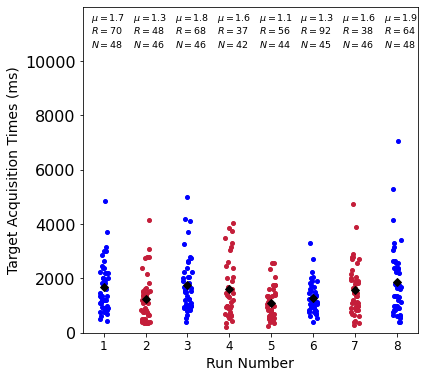

In [25]:
# 4/13 Day

c1 = '#c41e3a'
c3 = '#CC5500'
c2 = 'b'

print('4/13 Day')
print(' ')

print('4D decoder: 1 vs 2 finger targets')
print(' ')
print('4DOF Decoder/Task: 1 finger target')
print('Last two were retrained')
files_list_1 = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153016_(44).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153616_(46).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155107_(50).mat']
AcqTimes_1Fing, Rate_1Fing = CalculateTrialStats(files_list_1,FingSel=[0, 1, 2, 5], numFings=6, plotfig=False, returnRate=True, NumNewTargets=1)

print(' ')

print('4DOF Decoder/Task: 2 finger target')
print('Last two were retrained')
files_list_2 = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_152652_(43).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153321_(45).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154300_(48).mat','20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155425_(51).mat']
AcqTimes_2Fing, Rate_2Fing = CalculateTrialStats(files_list_2,FingSel=[0, 1, 2, 5], numFings=6, plotfig=False, returnRate=True)

print('')

print('Summary Stats')
file_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_152652_(43).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153016_(44).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153321_(45).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153616_(46).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154300_(48).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155107_(50).mat',
             '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155425_(51).mat']
colors = [c2,c1,c2,c1,c1,c2,c1,c2]
newTargs = [2,1,2,1,1,2,1,2]

direct_name = OUTPUT_FIG_DIR
file_name = 'Supp1_1v2Fings'

AcqTimes = CalculateTrialStats(file_list,FingSel=[0, 1, 2, 5], numFings=6, colors=colors,NumNewTargets=newTargs,fig_fn=direct_name+file_name)

print(' ')

perChange = 100*(np.mean(AcqTimes_1Fing)-np.mean(AcqTimes_2Fing))/np.mean(AcqTimes_2Fing)
p_value = stats.ttest_ind(AcqTimes_1Fing, AcqTimes_2Fing,alternative='two-sided')[1]
print('Percent change of acquisition time with 1 new targets from 2 new targets: %s' %round(perChange,2))
print('P-value: %s' %p_value)

statsMatlab['AcqTimes_1Fing'] = AcqTimes_1Fing
statsMatlab['AcqTimes_2Fing']= AcqTimes_2Fing

perChange = 100*(np.mean(Rate_1Fing)-np.mean(Rate_2Fing))/np.mean(Rate_2Fing)
p_value = stats.ttest_ind(Rate_1Fing, Rate_2Fing,alternative='two-sided')[1]
print('Percent change of acquisition rate with 1 new targets from 2 new targets: %s' %round(perChange,2))
print('P-value: %s' %p_value)

statsMatlab['AcqTimes_1Fing'] = AcqTimes_1Fing
statsMatlab['AcqTimes_2Fing']= AcqTimes_2Fing

statsMatlab['Rate_1Fing'] = Rate_1Fing
statsMatlab['Rate_2Fing']= Rate_2Fing

In [26]:
def SegmentTrials(files_list, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, goodChans=np.array(range(192)), condSamp=0):

    # Dimensionality parameters
    GoPeriod = 500 #ms
    HT = 500 #ms
    DelayPeriod =200 #ms
    dt_ms = dt*1e3
    zScore = True
    
    if len(FingSel) == 4:
        Lexicon = np.array([[1,1,0],[1,0,1],[0,1,1],[0,0,1],[0,1,0],[1,0,0]])
        dimKeep = np.array([0,2,3])
    elif len(FingSel) == 2:
        Lexicon = np.array([[1,1]])
        dimKeep = np.array([0,1])
    
    vocab = np.array([])
    trialNum = np.array([])
    trialInd = 0    
    DataMove = np.array([]).reshape(-1,goodChans.shape[0])
    VelInt = np.array([]).reshape(-1,len(FingSel))
    
    for k in range(len(files_list)):

        filename = files_list[k]
        
        inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial = LoadData(filename, filepath, FingSel=FingSel, numFings=numFings, dt=dt, zScore=zScore)
        binNeural = gaussian_filter1d(binNeural,3,axis=0)
        binNeural = binNeural[:,goodChans]
    
        # Bin Time
        idx = np.array(range(len(binTarg)))        

        # Target Size
        Target_Size = 2*float(inData['fn_hold_threshold'])

        # Nonzero when the target has changed position
        TranLog = np.append(np.zeros([1]), np.sum(np.abs(np.diff(binTarg,axis=0)),1),axis=0)

        # Start time of each trial and start index
        BegTargTime = np.append(binNeuralTime[:1],binNeuralTime[TranLog != 0],axis=0)
        BegTargTime_idx = np.append(np.array([0]),idx[TranLog != 0])

        # End time of each trial and last index
        EndTargTime = np.append(BegTargTime[1:]-dt_ms,binNeuralTime[-1:],axis=0)
        EndTargTime_idx = np.append(BegTargTime_idx[1:]-1,[binTarg.shape[0]-1],axis=0)
        
        AllTargs = binTarg[BegTargTime_idx,:]
        Trial_Success = [np.all(np.abs(AllTargs[k,:]-binPos[EndTargTime_idx[k]-int(HT/dt_ms)+1:EndTargTime_idx[k]+1,FingSel])<Target_Size/2) for k in range(AllTargs.shape[0])]
        
        EffectorActive = np.sign(np.diff(AllTargs,axis=0))*np.ceil(np.abs(np.diff(AllTargs,axis=0)))
        EffectorActive = np.append(np.zeros_like(EffectorActive[0:1,:]),EffectorActive,axis=0)
        EffectorActive = EffectorActive[:,dimKeep].astype(int)
        
        DimensionsActive = np.sign(np.diff(AllTargs,axis=0))*np.ceil(np.round(np.abs(np.diff(AllTargs,axis=0)),10))
        DimensionsActive = np.append(np.zeros_like(DimensionsActive[0:1,:]),DimensionsActive,axis=0)
        
        for m in range(BegTargTime.shape[0]):
            
            if (EndTargTime[m]-BegTargTime[m]) > (GoPeriod+DelayPeriod+HT) and int(np.round((EndTargTime[m]-BegTargTime[m])/dt_ms)) == EndTargTime_idx[m]-BegTargTime_idx[m] and Trial_Success[m]:
                vocab_k = np.all(np.abs(EffectorActive[m,:])==Lexicon,axis=1)
                
                if np.any(vocab_k):
                    vocab = np.append(vocab,np.argwhere(vocab_k)[0,0]*np.ones(np.round(GoPeriod/dt_ms).astype(int)))
                    trialNum = np.append(trialNum,trialInd*np.ones(np.round(GoPeriod/dt_ms).astype(int)))
                    VelInt = np.append(VelInt,np.matmul(np.ones([np.round(GoPeriod/dt_ms).astype(int),1]),DimensionsActive[m:m+1,:]),axis=0)
                    DataMove = np.append(DataMove,binNeural[BegTargTime_idx[m]+int(DelayPeriod/dt_ms):BegTargTime_idx[m]+int((DelayPeriod+GoPeriod)/dt_ms),goodChans],axis=0)
                    trialInd += 1
    
    ###
    # Now average these for each condition
    ###
    
    # Initialize Variables
    trialNum = trialNum.astype(int)

    # Select which DOF are active and make sure at least one DOF is active
    DimActUniq = np.unique(VelInt,axis=0)
    DimActUniq = DimActUniq[np.argwhere(np.sum(np.abs(DimActUniq),axis=1)>=1)[:,0],:]

    if condSamp>0:
        NumT_Move = np.round(GoPeriod/dt_ms).astype(int)
    else:
        NumT_Move = int(np.round(GoPeriod/dt_ms))

    trialNum_new = np.zeros([DimActUniq.shape[0]*NumT_Move])

    if condSamp<0:
        # Add more samples per condition
        DataMove_new = np.zeros([goodChans.shape[0],DimActUniq.shape[0]*NumT_Move*np.abs(condSamp)])
        trialNum_new = np.zeros([DimActUniq.shape[0]*NumT_Move*np.abs(condSamp)])
    elif condSamp>=0:
        DataMove_new = np.zeros([goodChans.shape[0],DimActUniq.shape[0]*NumT_Move])

    VelInt_new = np.array([]).reshape(-1,len(FingSel))
    trialUniq = np.unique(trialNum)

    for m in range(DimActUniq.shape[0]):

        ind_trial = np.argwhere(np.all(VelInt==DimActUniq[m],axis=1))
        trialUniq = np.unique(trialNum[ind_trial])
        NumberOfTrials = trialUniq.shape[0]

        # indexing along condition
        dim_ind_move = m*NumT_Move

        if condSamp>0:
            # compress data to fit in condSamp samples
            DataMove_k = np.zeros([goodChans.shape[0],condSamp])
        else:
            DataMove_k = np.array([]).reshape(goodChans.shape[0],NumT_Move,-1)

        for m2 in range(NumberOfTrials):
            ind_trial = np.argwhere(trialUniq[m2]==trialNum)
            if condSamp>0:
                # when we are compressing, choose the intervals to average to give us the numer of samples we want
                indCond_move = np.round(np.linspace(0,NumT_Move-1,condSamp+1)).astype(int)
                for m3 in range(condSamp):
                    # compress into each sample and divide by number of trials included for each condition (to get the mean value)
                    DataMove_k[:,m3:m3+1] += np.transpose(np.mean(DataMove[ind_trial[indCond_move[m3]][0]:ind_trial[indCond_move[m3+1]][0],goodChans],axis=0).reshape(1,-1))/NumberOfTrials
            else:
                # concatenate all the samples for each condition and will average later
                DataMove_k = np.append(DataMove_k,np.transpose(DataMove[ind_trial,goodChans]).reshape(goodChans.shape[0],ind_trial.shape[0],1),axis=2)

        if condSamp==0:
            DataMove_k = np.squeeze(np.mean(DataMove_k,axis=2))
        elif condSamp<0:
            # when expanding the number of samples per condition, split the expanded DataMove_k array into sub-arrays
            indSplit = np.array_split(np.array(range(DataMove_k.shape[2])),np.abs(condSamp))
            DataMove_k2 = np.array([]).reshape(goodChans.shape[0],-1)
            trialNum_new_k = np.array([])
            for kind in range(len(indSplit)):
                # concatenate instances of this condition into a longer array with more samples
                DataMove_k2 = np.append(DataMove_k2,np.squeeze(np.mean(DataMove_k[:,:,indSplit[kind]],axis=2)),axis=1)
                # we also expand the number of tirals included
                trialNum_new_k = np.append(trialNum_new_k,(m*np.abs(condSamp)+kind)*np.ones([NumT_Move]))
            DataMove_k = DataMove_k2

        if condSamp < 0:
            DataMove_new[:,dim_ind_move:dim_ind_move+np.abs(condSamp)*NumT_Move] += DataMove_k
            trialNum_new[np.abs(condSamp)*dim_ind_move:np.abs(condSamp)*dim_ind_move+np.abs(condSamp)*NumT_Move] = trialNum_new_k
        elif condSamp == 0:
            DataMove_new[:,dim_ind_move:dim_ind_move+NumT_Move] += DataMove_k
            trialNum_new[dim_ind_move:dim_ind_move+NumT_Move] = m*np.ones([NumT_Move])
        elif condSamp > 0:
            DataMove_new[:,dim_ind_move:dim_ind_move+condSamp] += DataMove_k
            trialNum_new[dim_ind_move:dim_ind_move+condSamp] = m*np.ones([condSamp])

    DataMove = DataMove_new
    trialNum = trialNum_new
    
    return DataMove, trialNum


def DivideMat2Folds(DataMat,trialNum,folds):
    
    np.random.seed(seed=123)
    trialUniq = np.unique(trialNum)
    DataMat_folds = np.empty([folds,DataMat.shape[0],0])
    
    for k in range(trialUniq.shape[0]):
        ind_trial = np.argwhere(trialUniq[k]==trialNum)[:,0]
        
        #must be an even number
        addK = int(np.floor(ind_trial.shape[0]/folds))
        
        # divide indeices into 2 folds
        ind_trials_folds = np.random.choice(ind_trial,size=(folds,addK), replace=False)
        
        #initialize new matrix
        DataMatK = np.zeros([folds,DataMat.shape[0],addK])
        
        # place each conditions data into two folds
        for k2 in range(folds):
            DataMatK[k2,:,:] = DataMat[:,ind_trials_folds[k2,:]]
        
        DataMat_folds = np.append(DataMat_folds,DataMatK,axis=2)
    
    return DataMat_folds
    
                

In [27]:
def SegmentTrialsSNR(files_list, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, goodChans=np.array(range(192)), TrialAvg=False, AvgCond=False, condSamp=0, ConvSize=0, dimProc=False):

    # SNR parameters
    GoPeriod = 500 #ms
    HT = 500 #ms
    DelayPeriod = 200 #ms
    dt_ms = dt*1000
    
    if len(FingSel) == 4:
        Lexicon = np.array([[1,1,0],[1,0,1],[0,1,1],[0,0,1],[0,1,0],[1,0,0]])    
        dimKeep = np.array([0,2,3])
    elif len(FingSel) == 2:
        Lexicon = np.array([[1,1]])
        dimKeep = np.array([0,1])
    trialNum = np.array([])
    trialNumStop = np.array([])
    trialInd = 0
    
    if ConvSize == 0:
        DataMove = np.array([]).reshape(-1,goodChans.shape[0])
        DataStop = np.array([]).reshape(-1,goodChans.shape[0])
    else:
        DataMove = np.array([]).reshape(-1,goodChans.shape[0],ConvSize)
        DataStop = np.array([]).reshape(-1,goodChans.shape[0],ConvSize)
    
    VelInt = np.array([]).reshape(-1,len(FingSel))
    dVelMove = np.array([]).reshape(-1,len(FingSel))
    dVelStop = np.array([]).reshape(-1,len(FingSel))
    
    for k in range(len(files_list)):

        filename = files_list[k]
        
        inData, binNeuralTime, binNeural, binPos, binVel, binTarg, binTrial = LoadData(filename, filepath, FingSel=FingSel, numFings=numFings, dt=dt, zScore=True)

        #Add Time Windows
        if ConvSize > 0:
            Y_continuous_1 = np.zeros([int(binNeural.shape[0]), int(binNeural.shape[1]), ConvSize])
            Y_continuous_1[:, :, 0] = binNeural
            for m1 in range(ConvSize - 1):
                m = m1 + 1
                Y_continuous_1[m:, :, m] = binNeural[0:-m, :]
            binNeural = Y_continuous_1
    
            binNeural = binNeural[:,goodChans,:]
        else:
            binNeural = binNeural[:,goodChans]
        
        # Bin Time
        idx = np.array(range(len(binTarg)))

        # Target Size
        Target_Size = 2*float(inData['fn_hold_threshold'])

        # Nonzero when the target has changed position
        TranLog = np.append(np.zeros([1]), np.sum(np.abs(np.diff(binTarg,axis=0)),1),axis=0)

        # Start time of each trial and start index
        BegTargTime = np.append(binNeuralTime[:1],binNeuralTime[TranLog != 0],axis=0)
        BegTargTime_idx = np.append(np.array([0]),idx[TranLog != 0])

        # End time of each trial and last index
        EndTargTime = np.append(BegTargTime[1:]-dt_ms,binNeuralTime[-1:],axis=0)
        EndTargTime_idx = np.append(BegTargTime_idx[1:]-1,[binTarg.shape[0]-1],axis=0)
        
        AllTargs = binTarg[BegTargTime_idx,:]
        Trial_Success = [np.all(np.abs(AllTargs[k,:]-binPos[EndTargTime_idx[k]-int(HT/dt_ms)+1:EndTargTime_idx[k]+1,FingSel])<Target_Size/2) for k in range(AllTargs.shape[0])]
        
        EffectorActive = np.sign(np.diff(AllTargs,axis=0))*np.ceil(np.abs(np.diff(AllTargs,axis=0)))
        EffectorActive = np.append(np.zeros_like(EffectorActive[0:1,:]),EffectorActive,axis=0)
        EffectorActive = EffectorActive[:,dimKeep].astype(int)
        
        DimensionsActive = np.sign(np.diff(AllTargs,axis=0))*np.ceil(np.round(np.abs(np.diff(AllTargs,axis=0)),10))
        DimensionsActive = np.append(np.zeros_like(DimensionsActive[0:1,:]),DimensionsActive,axis=0).astype(int)
        
        for m in range(BegTargTime.shape[0]):
            
            if (EndTargTime[m]-BegTargTime[m]) > (GoPeriod+DelayPeriod+HT) and int(np.round((EndTargTime[m]-BegTargTime[m])/dt_ms)) == EndTargTime_idx[m]-BegTargTime_idx[m] and Trial_Success[m]:
                
                
                vocab_k = np.all(np.abs(EffectorActive[m,:])==Lexicon,axis=1)
                if np.any(vocab_k)==False:
                    continue
                indGo = np.array(range(BegTargTime_idx[m]+int(DelayPeriod/dt_ms),BegTargTime_idx[m]+int((DelayPeriod+GoPeriod)/dt_ms)))
                
                # my_vec will be target vector for dimensions not on the target
                my_vec = binTarg[indGo,:]-binPos[indGo][:,FingSel]
                my_vec[np.abs(my_vec)<(Target_Size/2)] = 0
                my_vec = np.sign(my_vec).astype(int)
                
                # ind2KeepRaw_temp will only keep time samples where the cued fingers are not on the target
                ind2keep=np.all(my_vec==DimensionsActive[m:m+1,:],axis=1)
                ind2keepRaw_temp=indGo[ind2keep]
                activeInd = np.array(np.abs(DimensionsActive[m,:])).astype(bool)
                
                ind2keepRaw = ind2keepRaw_temp.copy()
            
                if ind2keepRaw.shape[0] == 0:
                    continue
    
                VelInt = np.append(VelInt,np.matmul(np.ones([ind2keepRaw.shape[0],1]),DimensionsActive[m:m+1,:]),axis=0)
                DataMove = np.append(DataMove,binNeural[ind2keepRaw,:][:,goodChans],axis=0)
                DataStop = np.append(DataStop,binNeural[EndTargTime_idx[m]+1-int(HT/dt_ms):EndTargTime_idx[m]+1,goodChans],axis=0)
                
                    
    return DataMove, DataStop, VelInt



                

In [28]:
def pruneChannels(chans,chanSel):
    
    if chanSel<chans.shape[0]:
        indOut = np.random.choice(chans.shape[0], chanSel, replace=False)
        ChanOut = chans[indOut]
        ChanRem = np.array(list(set(chans)-set(ChanOut)))
    else:
        ChanOut = chans
        ChanRem = np.array([])
        
    ChanOut = ChanOut.astype(int)
    ChanRem = ChanRem.astype(int)
        
    return ChanOut, ChanRem



In [29]:
# Error Vector Magnitude

def CalculateDirSNR_WP(files_list, file_test = [], filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, goodChans=False, TrialAvg=False, AvgCond=False, Mov=True, alpha=1e3):
    
    ConvSize = 0 # should be 0
    numb_part = 6
    
    n_components = 20
    dSNR_save = np.array([])
    fSNR_save = np.array([])
    sin_save = np.array([])
    decSNR_save = np.array([])
    y1_save = np.array([]).reshape(-1,len(FingSel))
    VelTest_save = np.array([]).reshape(-1,len(FingSel))
    dVel_save = np.array([]).reshape(-1,len(FingSel))
    
    DataMove, DataStop, VelInt = SegmentTrialsSNR(files_list,TrialAvg=TrialAvg, FingSel=FingSel, ConvSize=ConvSize)        
    
    if np.invert(type(goodChans)==type(False)):
        DataMove = DataMove[:,goodChans]
        DataStop = DataStop[:,goodChans]
        n_components = np.minimum(n_components,goodChans.shape[0])

    # normalize to unit target vector
    VelInt = VelInt/np.sqrt(np.sum(np.abs(VelInt)**2,axis=1)).reshape(-1,1)

    # Shuffle data into partitions
    ind_shuff = np.array(range(DataMove.shape[0]))
    np.random.shuffle(ind_shuff)
    ind_part = np.array_split(ind_shuff,numb_part)

    for k in range(numb_part):
        test_part_ind = k
        train_part_ind = np.setdiff1d(np.arange(numb_part),test_part_ind)
        test_ind = ind_part[test_part_ind]
        train_ind = np.concatenate([ind_part[x][:] for x in train_part_ind])
    
        DataTrain = DataMove[train_ind,:]
        VelTrain = VelInt[train_ind,:]
        DataTest = DataMove[test_ind,:]
        VelTest = VelInt[test_ind,:]
            
        # PCA
        pca = PCA(n_components=n_components)
        pca.fit(np.squeeze(DataTrain))
        DataTrain_T = pca.transform(DataTrain)
        DataTest_T = pca.transform(DataTest)
        DataStop_T =  pca.transform(DataStop)
        reg1 = LinearRegression().fit(DataTrain_T, VelTrain)
        
        # No PCA but Ridge
#         DataTrain_T = DataTrain.copy()
#         DataTest_T = DataTest.copy()
#         DataStop_T =  DataStop.copy()
#         reg1 = Ridge(alpha=alpha).fit(DataTrain_T, VelTrain)
        
        y1 = reg1.predict(DataTest_T)
        sis = reg1.predict(DataStop_T)

        # Compute dot product between true and predicted signal (VelTest is a unit vector)
        SignalComponent = np.sum(y1*VelTest,axis=1)

        # Compute the error angle
        theta = np.arccos(SignalComponent/(np.sqrt(np.sum(y1**2,axis=1))))
        
        # Compute the error component
        ErrorComponent = np.sin(theta)*np.sqrt(np.sum(y1**2,axis=1))
        
        # Compute the directional SNR
        dSNR = np.mean(SignalComponent)/np.sqrt(np.var(ErrorComponent)+np.mean(ErrorComponent)**2)
        
        # Compute Signal Independent Noise (during hold time)
        # Scalar
        sin = np.mean(np.sqrt(np.var(sis,axis=0)+np.mean(sis,axis=0)**2))

        # Functional SNR
        reg2 = LinearRegression().fit(VelTest,y1)
        y2 = reg2.predict(VelTest)
        err = np.std(y2-VelTest,axis=0)
        diagTerms = np.diag(reg2.coef_)
        fSNR = np.mean(diagTerms)/np.mean(err)
        
        
        # Add to arrays
        dSNR_save = np.append(dSNR_save,dSNR)
        fSNR_save = np.append(fSNR_save,fSNR)
        sin_save = np.append(sin_save,sin)
        y1_save = np.append(y1_save,y1,axis=0)
        VelTest_save = np.append(VelTest_save,VelTest,axis=0)
    
    dSNR_out = np.mean(dSNR_save)
    fSNR_out = np.mean(fSNR_save)
    sin_out =np.mean(sin_save)
    rawData = [y1_save,VelTest_save,dVel_save]
    
    return dSNR_out, fSNR_out, sin_out, rawData

In [30]:
files_list = ['20230309/RedisMat/t5_t5.2023.03.09_Data_RedisMat_20230309_150822_(18).mat']
dSNR, fSNR, sin, rawData = CalculateDirSNR_WP(files_list, FingSel=[0, 1, 2, 5])
print(dSNR)

0.5313452166663344


In [31]:
def plotSNRvsChannel(chan_array,dSNR_array,labels=[],fitLine=False,fig_fn='SNRvsChannelCount', text=True):
    
    fig = plt.figure(facecolor='white')
    fig.set_size_inches(len(np.unique(labels)), 6, forward=True)
    fig_0 = plt.figure(facecolor='white')
    ax_0 = plt.gca()
    
    # Initialization for the 3 tests
    mean_lines = np.zeros((chan_array.shape[1],3))
    mean_N = np.zeros([3])
    
    if len(dSNR_array.shape) <= 1:
        dSNR_array = dSNR_array.reshape(-1,1)
        
    for k in range(dSNR_array.shape[1]):

        # Temp variables
        dSNR = dSNR_array[:,k]
        chan_array = chan_array.reshape(-1,1)
        chan_array = chan_array[:,0]
        
        if len(labels) >= k+1:
            lab_k = labels[k]
        else:
            lab_k = ' '
        
        if labels[k][0:15]=='2DOF: 2 fingers':
            mean_N[0] += 1
            mean_lines[:,0:1] += dSNR.reshape(-1,1)
            color_k = '#ffeaea'
            plt.plot(chan_array,dSNR,color=color_k)
                
        elif labels[k][0:15]=='4DOF: 2 fingers':
            mean_N[1] += 1
            mean_lines[:,1:2] += dSNR.reshape(-1,1)
            color_k = '#e2e2fe'
            plt.plot(chan_array,dSNR,color=color_k)
                
        elif labels[k][0:17]=='Day 8 (1 Fingers)':
            mean_N[2] += 1
            mean_lines[:,2:3] += dSNR.reshape(-1,1)
            color_k = '#CBC3E3'
            plt.plot(chan_array,dSNR,color=color_k)
                
        else:
            color_k = '#D3D3D3'
            continue

        plt.xlabel('Number of Channels',fontsize=18)
        plt.ylabel('Directional SNR',fontsize=18)
        plt.title('Directional SNR',fontsize=24)

    if fitLine:
        print('2DOF')
        r_value_0, exp_0 = plotEstLine(chan_array,mean_lines[:,0]/mean_N[0],color='#c41e3a')
        print('4DOF')  
        r_value_1, exp_1 = plotEstLine(chan_array,mean_lines[:,1]/mean_N[1],color='#00274C')
        print('4DOF: 1 finger')  
        r_value_2, exp_2 = plotEstLine(chan_array,mean_lines[:,2]/mean_N[2],color='#9A0EEA')

    plt.plot(chan_array,mean_lines[:,0]/mean_N[0],label='2DOF',color='#c41e3a', linestyle='-', marker='.')
    plt.plot(chan_array,mean_lines[:,1]/mean_N[1],label='4DOF',color='#00274C', linestyle='-', marker='.')
    plt.plot(chan_array,mean_lines[:,2]/mean_N[2],label='4DOF, 1Fing',color='#9A0EEA', linestyle='-', marker='.')
    
    if fitLine:
        plt.text(35, mean_lines[mean_lines.shape[0]-1,0]/mean_N[0]+.1, '$exp=$'+str(round(exp_0,2))+' , $R^2=$'+str(round(r_value_0,2)), fontsize = 9.5, color='#c41e3a')
        plt.text(50, mean_lines[mean_lines.shape[0]-1,1]/mean_N[1]-0.6, '$exp=$'+str(round(exp_1,2))+' , $R^2=$'+str(round(r_value_1,2)), fontsize = 9.5, color='#00274C')
        plt.text(50, mean_lines[mean_lines.shape[0]-1,2]/mean_N[2]-0.6, '$exp=$'+str(round(exp_2,2))+' , $R^2=$'+str(round(r_value_2,2)), fontsize = 9.5, color='#9A0EEA')
    
    ax_0.set_xscale('log')    
    ax_0.xaxis.set_major_formatter(mticker.ScalarFormatter())
    
    if len(labels)==dSNR_array.shape[1]:
        ax_0.legend()
    
    plt.savefig(fig_fn+'.pdf',dpi=900,facecolor=fig_0.get_facecolor(),bbox_inches = "tight", format='pdf')
    plt.savefig(fig_fn+'.jpg',dpi=300,facecolor=fig_0.get_facecolor(),bbox_inches = "tight", format='jpg')
                
    return
                
                
def plotEstLine(x,y,color='k'):
                
    indPlot = int(np.round(0.25*x.shape[0]))

    p = np.polyfit(np.log10(x[indPlot:]),np.log10(y[indPlot:]),1)
    A = np.vstack([np.log10(x[indPlot:]),np.ones(len(x[indPlot:]))]).T
    m, c = np.linalg.lstsq(A, np.log10(y[indPlot:]), rcond=None)[0]

    xEst = x.copy()
    yEst = 10**(m*np.log10(xEst))*10**c
    
    r_value = r2_score(np.log10(y[indPlot:]), m*np.log10(x[indPlot:])+c)

    plt.plot(xEst,yEst,color=color, linestyle='--')
    
    print('Exponent is: %s' %(str(m)))
    print('r2_value is: %s' %(str(r_value)))
    print(p)
    
    return r_value, m
    

def CollectChannelData2(files_list,FingSel=[0, 1, 2, 5]):
    
    stepPerc = 5
    chans = np.array(range(192))
    chan_Array = np.array([])
    chanStore = 0

    dSNR_Array_save = np.array([])
    sin_Array_save = np.array([])

    for k in range(0,100+stepPerc,stepPerc):
        ChanSel = int(np.round(k*chans.shape[0]/100))-chanStore
        ChanSel = np.max(np.array([5,ChanSel]))
        chanStore += ChanSel
        chan_Array = np.append(chan_Array,chanStore)

        dSNR_save = np.array([])
        sin_save = np.array([])

        for m in range(50):
            
            chan2, _ = pruneChannels(chans,chanStore)    
            dSNR, _, sin, rawData = CalculateDirSNR_WP(files_list, goodChans=chan2, FingSel=[0, 1, 2, 5])

            dSNR_save = np.append(dSNR_save,dSNR)
            sin_save = np.append(sin_save,sin)
    
        dSNR_Array_save = np.append(dSNR_Array_save,np.mean(dSNR_save))
        sin_Array_save = np.append(sin_Array_save,np.mean(sin_save))

        print(' ')
        print('Number of Channels: %s' %(chanStore))
        print('Directional SNR: %s +/- %s' %(np.mean(dSNR_save),(np.std(dSNR_save)/np.sqrt(dSNR_save.shape[0]))))
        print(' ')
        
    return dSNR_Array_save, sin_Array_save, rawData, chan_Array
    

 
Number of Channels: 5
Directional SNR: 0.2092927023724566 +/- 0.006963556906300599
 
 
Number of Channels: 10
Directional SNR: 0.19841342259208442 +/- 0.006651508731350173
 
 
Number of Channels: 19
Directional SNR: 0.23428400586514062 +/- 0.008957558268076144
 
 
Number of Channels: 29
Directional SNR: 0.26112811037173367 +/- 0.010140593573015461
 
 
Number of Channels: 38
Directional SNR: 0.2902081496213549 +/- 0.009165539608477956
 
 
Number of Channels: 48
Directional SNR: 0.31197848575849 +/- 0.008523123009045322
 
 
Number of Channels: 58
Directional SNR: 0.34768567851028753 +/- 0.008387237196709751
 
 
Number of Channels: 67
Directional SNR: 0.36139619243584775 +/- 0.008552172939101096
 
 
Number of Channels: 77
Directional SNR: 0.3746931024959488 +/- 0.0074236634971550875
 
 
Number of Channels: 86
Directional SNR: 0.3923777786695424 +/- 0.008969237868388626
 
 
Number of Channels: 96
Directional SNR: 0.40442682569952276 +/- 0.006523708013440842
 
 
Number of Channels: 106
Di

 
Number of Channels: 86
Directional SNR: 0.5443349131446099 +/- 0.009245599969105766
 
 
Number of Channels: 96
Directional SNR: 0.5762272915155805 +/- 0.007445922258769973
 
 
Number of Channels: 106
Directional SNR: 0.581310127189634 +/- 0.007873414168995627
 
 
Number of Channels: 115
Directional SNR: 0.6065915588787063 +/- 0.007832891704455367
 
 
Number of Channels: 125
Directional SNR: 0.6323260959838417 +/- 0.005685005120790901
 
 
Number of Channels: 134
Directional SNR: 0.6394461316653774 +/- 0.0067796461583594
 
 
Number of Channels: 144
Directional SNR: 0.6573429876027694 +/- 0.005701818627118802
 
 
Number of Channels: 154
Directional SNR: 0.6736909781447247 +/- 0.004496727378831436
 
 
Number of Channels: 163
Directional SNR: 0.690751690320498 +/- 0.0038341809873750554
 
 
Number of Channels: 173
Directional SNR: 0.6950740667457116 +/- 0.004490349480822483
 
 
Number of Channels: 182
Directional SNR: 0.7029096726512417 +/- 0.003409201637101222
 
 
Number of Channels: 192


 
Number of Channels: 173
Directional SNR: 1.387110420974278 +/- 0.007501140813983518
 
 
Number of Channels: 182
Directional SNR: 1.4023284621707626 +/- 0.006216935422314662
 
 
Number of Channels: 192
Directional SNR: 1.4274028627139952 +/- 0.004758352542052984
 
 
Number of Channels: 5
Directional SNR: 0.4702052589309463 +/- 0.028145834891329668
 
 
Number of Channels: 10
Directional SNR: 0.5700769943091311 +/- 0.028530731241037166
 
 
Number of Channels: 19
Directional SNR: 0.7819963453893197 +/- 0.030688854514157034
 
 
Number of Channels: 29
Directional SNR: 0.9527837919017194 +/- 0.025189126771722904
 
 
Number of Channels: 38
Directional SNR: 1.0116418885965996 +/- 0.02379191373123012
 
 
Number of Channels: 48
Directional SNR: 1.149021745149871 +/- 0.026065480280314343
 
 
Number of Channels: 58
Directional SNR: 1.1833379008306049 +/- 0.02726494627140631
 
 
Number of Channels: 67
Directional SNR: 1.2975349607600202 +/- 0.025826909588636163
 
 
Number of Channels: 77
Direction

<Figure size 216x432 with 0 Axes>

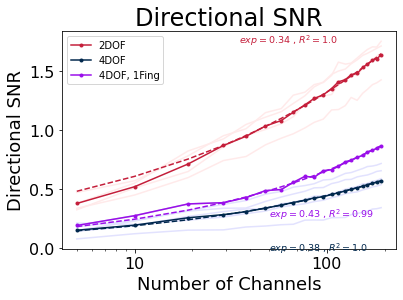

In [32]:
np.random.seed(0)

direct_name = OUTPUT_FIG_DIR
file_name = 'SNRvsChannel_dSNR_FinalFinal_PCA'

labels = []

y1_save_2DOF = np.array([]).reshape(-1,4)
y1_save_4DOF_2targ = np.array([]).reshape(-1,4)
y1_save_4DOF_1targ = np.array([]).reshape(-1,4)
dVel_2DOF = np.array([]).reshape(-1,4)
dVel_4DOF_2targ = np.array([]).reshape(-1,4)
dVel_4DOF_1targ = np.array([]).reshape(-1,4)
VelInt_save_2DOF = np.array([]).reshape(-1,4)
VelInt_save_4DOF_2targ = np.array([]).reshape(-1,4)
VelInt_save_4DOF_1targ = np.array([]).reshape(-1,4)

dSNR_save = np.array([]).reshape(-1,1)
sin_save = np.array([]).reshape(-1,1)

#######
files_list = ['20230309/RedisMat/t5_t5.2023.03.09_Data_RedisMat_20230309_150822_(18).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = dSNR.reshape(-1,1)
sin_save = sin.reshape(-1,1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']

#######
files_list = ['20230314/RedisMat/t5_t5.2023.03.14_Data_RedisMat_20230314_155042_(17).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']

#######
files_list = ['20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145004_(15).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145406_(16).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_150013_(17).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']
#######
files_list = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152402_(24).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152739_(25).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153159_(26).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153613_(27).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154046_(28).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154505_(29).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155009_(30).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155427_(31).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']
#######
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160835_(33).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_152652_(43).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153321_(45).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154300_(48).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155425_(51).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_2targ = np.append(y1_save_4DOF_2targ, rawData[0], axis=0)
VelInt_save_4DOF_2targ = np.append(VelInt_save_4DOF_2targ, rawData[1], axis=0)
dVel_4DOF_2targ = np.append(dVel_4DOF_2targ, rawData[2], axis=0)

labels = labels+['4DOF: 2 fingers']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153016_(44).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153616_(46).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155107_(50).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 1, 2, 5])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_4DOF_1targ = np.append(y1_save_4DOF_1targ, rawData[0], axis=0)
VelInt_save_4DOF_1targ = np.append(VelInt_save_4DOF_1targ, rawData[1], axis=0)
dVel_4DOF_1targ = np.append(dVel_4DOF_1targ, rawData[2], axis=0)

labels = labels+['Day 8 (1 Fingers)']
#######
SNR_Data = dict([])

SNR_Data['chan_Array'] = chan_Array
SNR_Data['dSNR_save'] = dSNR_save
SNR_Data['sin_save'] = sin_save

SNR_Data['y1_save_4DOF_1targ'] = y1_save_4DOF_1targ
SNR_Data['VelInt_save_4DOF_1targ'] = VelInt_save_4DOF_1targ
SNR_Data['dVel_4DOF_1targ'] = dVel_4DOF_1targ

SNR_Data['y1_save_4DOF_2targ'] = y1_save_4DOF_2targ
SNR_Data['VelInt_save_4DOF_2targ'] = VelInt_save_4DOF_2targ
SNR_Data['dVel_4DOF_2targ'] = dVel_4DOF_2targ

SNR_Data['labels'] = labels
sio.savemat(file_name+'.mat', SNR_Data)
#######
files_list = ['20230321/RedisMat/t5_t5.2023.03.21_Data_RedisMat_20230321_162754_(18).mat',
              '20230321/RedisMat/t5_t5.2023.03.21_Data_RedisMat_20230321_163420_(19).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 2])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_2DOF = np.append(y1_save_2DOF, rawData[0], axis=0)
VelInt_save_2DOF = np.append(VelInt_save_2DOF, rawData[1], axis=0)
dVel_2DOF = np.append(dVel_2DOF, rawData[2], axis=0)

labels = labels+['2DOF: 2 fingers']
#######
files_list = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_135514_(7).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140002_(8).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140335_(9).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 2])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_2DOF = np.append(y1_save_2DOF, rawData[0], axis=0)
VelInt_save_2DOF = np.append(VelInt_save_2DOF, rawData[1], axis=0)
dVel_2DOF = np.append(dVel_2DOF, rawData[2], axis=0)

labels = labels+['2DOF: 2 fingers']
#######
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_163924_(41).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164821_(44).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_170346_(48).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 2])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_2DOF = np.append(y1_save_2DOF, rawData[0], axis=0)
VelInt_save_2DOF = np.append(VelInt_save_2DOF, rawData[1], axis=0)
dVel_2DOF = np.append(dVel_2DOF, rawData[2], axis=0)

labels = labels+['2DOF: 2 fingers']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140435_(21).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141525_(25).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142510_(28).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_144121_(32).mat']
dSNR, sin, rawData, chan_Array = CollectChannelData2(files_list, FingSel=[0, 2])

dSNR_save = np.append(dSNR_save,dSNR.reshape(-1,1),axis=1)
sin_save = np.append(sin_save,sin.reshape(-1,1),axis=1)

y1_save_2DOF = np.append(y1_save_2DOF, rawData[0], axis=0)
VelInt_save_2DOF = np.append(VelInt_save_2DOF, rawData[1], axis=0)
dVel_2DOF = np.append(dVel_2DOF, rawData[2], axis=0)

labels = labels+['2DOF: 2 fingers']
#######
SNR_Data = dict([])

SNR_Data['chan_Array'] = chan_Array
SNR_Data['dSNR_save'] = dSNR_save
SNR_Data['sin_save'] = sin_save

SNR_Data['y1_save_4DOF_1targ'] = y1_save_4DOF_1targ
SNR_Data['VelInt_save_4DOF_1targ'] = VelInt_save_4DOF_1targ
SNR_Data['dVel_4DOF_1targ'] = dVel_4DOF_1targ

SNR_Data['y1_save_4DOF_2targ'] = y1_save_4DOF_2targ
SNR_Data['VelInt_save_4DOF_2targ'] = VelInt_save_4DOF_2targ
SNR_Data['dVel_4DOF_2targ'] = dVel_4DOF_2targ

SNR_Data['y1_save_2DOF'] = y1_save_2DOF
SNR_Data['VelInt_save_2DOF'] = VelInt_save_2DOF
SNR_Data['dVel_2DOF'] = dVel_2DOF

SNR_Data['labels'] = labels
sio.savemat(file_name+'.mat', SNR_Data)

################

direct_name = OUTPUT_FIG_DIR
inData = sio.loadmat(file_name+'.mat')
plotSNRvsChannel(inData['chan_Array'],inData['dSNR_save'],fitLine=True,labels=inData['labels'],fig_fn=direct_name+file_name)


Channels:
[  5.  10.  19.  29.  38.  48.  58.  67.  77.  86.  96. 106. 115. 125.
 134. 144. 154. 163. 173. 182. 192.]
Estimated from Channels:
[ 48.  58.  67.  77.  86.  96. 106. 115. 125. 134. 144. 154. 163. 173.
 182. 192.]
2DOF
Exponent is: 0.3382201101382046
r2_value is: 0.9967771952489922
[ 0.33822011 -0.55486137]
4DOF
Exponent is: 0.3765162440457255
r2_value is: 0.9993166261233571
[ 0.37651624 -1.10445849]
4DOF: 1 finger
Exponent is: 0.4313811839600346
r2_value is: 0.9900581428532176
[ 0.43138118 -1.04618608]


<Figure size 216x432 with 0 Axes>

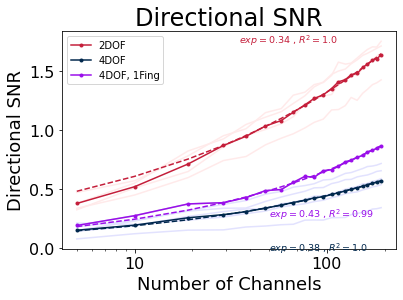

In [33]:
file_name = 'SNRvsChannel_dSNR_FinalFinal_PCA'
direct_name = OUTPUT_FIG_DIR

inData = sio.loadmat(file_name+'.mat')
x = inData['chan_Array']
print('Channels:')
print(x[0,:])
print('Estimated from Channels:')
indPlot = int(np.round(0.25*x.shape[1]))
print(x[0,indPlot:])
plotSNRvsChannel(inData['chan_Array'],inData['dSNR_save'],fitLine=True,labels=inData['labels'],fig_fn=direct_name+file_name+'_dSNR')

In [42]:
def PlotSampleSNRData(uniqueSet,y1,fig_nm='SNRPopData'):
    colors = ['b','g','r','m']
    
    np.set_printoptions(threshold=sys.maxsize)
    
    maxVal = 1.5*np.max(np.abs(uniqueSet))
    num = np.sum(np.max(np.abs(y1),axis=1)>maxVal)
    
    fig = plt.figure()
    fig.set_size_inches(5, 5, forward=True)
    
    for mm in range(uniqueSet.shape[0]):
        indSel = np.all(VelTest==uniqueSet[mm:mm+1,:],axis=1)
        plt.scatter(y1[indSel,0],y1[indSel,1],s=25,marker='.',color=colors[mm])
        plt.arrow(0,0,uniqueSet[mm,0],uniqueSet[mm,1],edgecolor='k',facecolor=colors[mm],shape='full',width=.03)

        plt.xlim([-maxVal,maxVal])
        plt.ylim([-maxVal,maxVal])
        plt.xlabel('Thumb \nFlexion (+) / Extension (-)')
        plt.ylabel('Index-Middle \nFlexion (+) / Extension (-)')
    
    print('Number of Data Points Not shown (out of range): %s' %num)
    print('Number of All Data Points: %s' %y1.shape[0])
    
    plt.savefig(fig_nm+'.eps',dpi=300,facecolor=fig.get_facecolor(),format='eps')
    plt.savefig(fig_nm+'.jpg',dpi=300,facecolor=fig.get_facecolor(),format='jpg')
    plt.savefig(fig_nm+'.pdf',dpi=300,facecolor=fig.get_facecolor(),format='pdf')
    
    return

Data
Number of Data Points Not shown (out of range): 140
Number of All Data Points: 3748
 


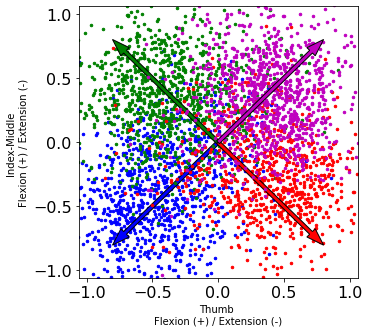

In [43]:
VelTest = inData['VelInt_save_2DOF'][:,np.array([0,2])]
uniqueSet = np.unique(VelTest,axis=0)

print('Data')
direct_name = OUTPUT_FIG_DIR
file_name = 'PopRaw2DOF'
PlotSampleSNRData(uniqueSet,inData['y1_save_2DOF'][:,np.array([0,2])],fig_nm=direct_name+file_name)
print(' ')

In [36]:
def CalculateDimensionality(files_list, filepath=FILE_PATH_DATA, FingSel=[0, 1, 2, 5], numFings=6, dt=0.05, goodChans=np.array(range(192)), CV=True, condSamp=0):
    
    fold = 2
    
    # Load Data
    DataMove, trialNum = SegmentTrials(files_list, FingSel=FingSel, condSamp=condSamp)
    
    if CV:
        
        # DataMoveCV Dimensions: folds x number of electrodes x time steps per condition
        DataMoveCV = DivideMat2Folds(DataMove,trialNum,fold)
        DataMoveCV_zeroMean = np.zeros_like(DataMoveCV)
        
        # Subtract the mean
        for k in range(fold):
            DataMoveCV_zeroMean[k,:,:] = np.transpose(np.transpose(DataMoveCV[k,:,:])-np.mean(DataMoveCV[k,:,:],axis=1))
        
        # Calculate the covariance matrix
        cov_CV = np.matmul(DataMoveCV_zeroMean[0,:,:],np.transpose(DataMoveCV_zeroMean[1,:,:]))
        evals, evecs = np.linalg.eig(cov_CV)
        
        # Calculate participation ratio (imaginary component is very small and discarded)
        PR = np.real(np.sum(evals)**2/np.sum(evals**2))
        
        print('PR = %s' %(PR))

    
    return PR, PR, PR    
    

In [37]:
files_list = ['20230309/RedisMat/t5_t5.2023.03.09_Data_RedisMat_20230309_150822_(18).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)

PR = 8.930071838904993


In [38]:
labels = []
dim_Save = np.array([])
dimDOF = np.array([])
labelsPlot = []

########
files_list = ['20230309/RedisMat/t5_t5.2023.03.09_Data_RedisMat_20230309_150822_(18).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
labels = labels+['Day 3 (2 Fingers)']
dimDOF = np.append(dimDOF, dim)
labelsPlot = labelsPlot+['4DOF4T']
########
files_list = ['20230314/RedisMat/t5_t5.2023.03.14_Data_RedisMat_20230314_155042_(17).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
labels = labels+['Day 4 (2 Fingers)']
dimDOF = np.append(dimDOF, dim)
labelsPlot = labelsPlot+['4DOF4T']
########
files_list = ['20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145004_(15).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_145406_(16).mat',
              '20230316/RedisMat/t5_t5.2023.03.16_Data_RedisMat_20230316_150013_(17).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['Day 5 (2 Fingers)']
labelsPlot = labelsPlot+['4DOF4T']
######
files_list = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152402_(24).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_152739_(25).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153159_(26).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_153613_(27).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154046_(28).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_154505_(29).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155009_(30).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_155427_(31).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['Day 6 (2 Fingers)']
labelsPlot = labelsPlot+['4DOF4T']
#######
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_155957_(30).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_160835_(33).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['Day 7 (2 Fingers)']
labelsPlot = labelsPlot+['4DOF4T']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153016_(44).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153616_(46).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154017_(47).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155107_(50).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0) 
dim_Save = np.append(dim_Save, dim)
labels = labels+['Day 8 (1 Fingers)']
dimDOF = np.append(dimDOF, dim)
labelsPlot = labelsPlot+['4DOF1T']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_152652_(43).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_153321_(45).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_154300_(48).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_155425_(51).mat']

dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 1, 2, 5], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['Day 8 (2 Fingers)']
labelsPlot = labelsPlot+['4DOF4T']

#######
files_list = ['20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_135514_(7).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140002_(8).mat',
              '20230323/RedisMat/t5_t5.2023.03.23_Data_RedisMat_20230323_140335_(9).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 2], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['2DOF 323']
labelsPlot = labelsPlot+['2DOF2T']
#######
files_list = ['20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_163924_(41).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_164821_(44).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_165350_(46).mat',
              '20230406/RedisMat/t5_t5.2023.04.06_Data_RedisMat_20230406_170346_(48).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 2], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['2DOF 406']
labelsPlot = labelsPlot+['2DOF2T']
#######
files_list = ['20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_140435_(21).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_141525_(25).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_142510_(28).mat',
              '20230413/RedisMat/t5_t5.2023.04.13_Data_RedisMat_20230413_144121_(32).mat']
dim, _, _ = CalculateDimensionality(files_list, FingSel=[0, 2], condSamp=0)
dim_Save = np.append(dim_Save, dim)
dimDOF = np.append(dimDOF, dim)
labels = labels+['2DOF 413']
labelsPlot = labelsPlot+['2DOF2T']
#######

print(' ')
print(labels)
print(dim_Save)

PR = 8.930071838904993
PR = 9.59189187768502
PR = 8.034280672257806
PR = 5.86278956166281
PR = 6.048337937402235
PR = 3.0684790917394738
PR = 6.450918035004972
PR = 2.1204603660950747
PR = 2.384593830571559
PR = 2.6888823504515416
 
['Day 3 (2 Fingers)', 'Day 4 (2 Fingers)', 'Day 5 (2 Fingers)', 'Day 6 (2 Fingers)', 'Day 7 (2 Fingers)', 'Day 8 (1 Fingers)', 'Day 8 (2 Fingers)', '2DOF 323', '2DOF 406', '2DOF 413']
[8.93007184 9.59189188 8.03428067 5.86278956 6.04833794 3.06847909
 6.45091804 2.12046037 2.38459383 2.68888235]


In [39]:
def PlotDimensionality(dim,labels,fig_fn='DimPlots',colors=[]):
    
    YLIM = 15
    
    fig = plt.figure(facecolor='white')
    fig.set_size_inches(3/4*len(files_list), 6, forward=True)
    listDims = []

    for rn_k in enumerate(np.unique(labels)):
        ind_k = rn_k[0]
        run_k = rn_k[1]
        
        ind_plot = np.where(run_k==np.array(labels))[0]
        adj_array = np.linspace(-.1, .1, num=ind_plot.shape[0])
        
        listDims += [dim[ind_plot]]

        color_k = 'c'
        if len(colors) >= ind_k+1:
            color_k = colors[ind_k]
        
        plt.plot(ind_k+1,np.mean(dim[ind_plot]),'D',color='k',markersize=10)
        plt.plot(ind_k+1-adj_array,dim[ind_plot],'o',color=color_k,markersize=4)
        

    plt.xlabel('Decoder and Task',fontsize=14)
    plt.ylabel('Dimensionality',fontsize=14)
    plt.xlim(0.5,len(np.unique(labels))+0.5)
    
    
    xticks = np.array(range(np.unique(labels).shape[0]))+1
    plt.xticks(xticks,xticks,fontsize=12)
    if len(labels)>0:
        ax = plt.gca()
        ax.set_xticklabels(np.unique(labels))

    plt.yticks(int(np.round(2/12*YLIM))*np.array(range(0,8),dtype=int),int(np.round(2/12*YLIM))*np.array(range(0,8),dtype=int))

    for kk in range(xticks.shape[0]):
        ind_temp = np.argwhere(np.array(labels)==np.unique(labels)[kk])
        plt.text(xticks[kk]-.3, 11/12*YLIM*np.ones_like(xticks)[kk], '$N=$'+str(len(ind_temp)), fontsize = 9.5, color='k')
        plt.text(xticks[kk]-.3, 11.5/12*YLIM*np.ones_like(xticks)[kk], '$\mu=$'+str(round(np.mean(dim[ind_temp]),1)), fontsize = 9.5, color='k')


    plt.ylim(0,YLIM)
        
    plt.savefig(fig_fn+'.pdf',dpi=900,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='pdf')
    plt.savefig(fig_fn+'.jpg',dpi=300,facecolor=fig.get_facecolor(),bbox_inches = "tight", format='jpg')
    
    perChange = 100*(np.mean(listDims[2])-np.mean(listDims[0]))/np.mean(listDims[0])
    print('Percent increase of dimensionality in 4D Dec over 2D Dec acquistion time (both on 2D Task): %s' %round(perChange,2))
    print('Two times the dimensionality in 2D : %s' %np.mean(2*listDims[0]))
    perChange = 100*(np.mean(listDims[2])-np.mean(2*listDims[0]))/np.mean(2*listDims[0])
    p_value = stats.ttest_ind(listDims[2], 2*listDims[0],alternative='two-sided')[1]

    print('Percent increase of dimensionality in 4D Dec over two times 2D Dec acquistion time (both on 2D Task): %s' %round(perChange,2))
    print('P-value: %s' %p_value)
    
    Dim2D = listDims[0]
    Dim4D = listDims[2]
    
    return Dim2D, Dim4D
    

Percent increase of dimensionality in 4D Dec over 2D Dec acquistion time (both on 2D Task): 212.2
Two times the dimensionality in 2D : 4.795957698078784
Percent increase of dimensionality in 4D Dec over two times 2D Dec acquistion time (both on 2D Task): 56.1
P-value: 0.02783608859304732


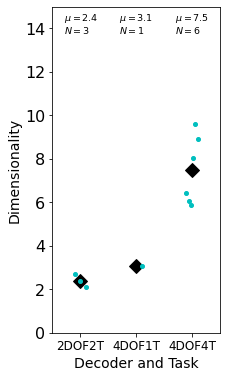

In [40]:
direct_name = OUTPUT_FIG_DIR
file_name = 'DimPlots2'
Dim2D, Dim4D = PlotDimensionality(dimDOF,labelsPlot,fig_fn=direct_name+file_name)

statsMatlab['Times2_Dim2D'] = 2*Dim2D
statsMatlab['Dim4D']= Dim4D

In [41]:
CourseRuns = np.array([4*60+36,5*60+17,4*60+27,3*60+38,2*60+45,3*60+30,3*60+32,2*60+53,4*60+14,2*60+59,2*60+58,3*60+30])
print(CourseRuns)

mCR = np.mean(CourseRuns)
semCR = np.std(CourseRuns)/np.sqrt(CourseRuns.shape[0])
stdCR = np.std(CourseRuns)

print('Mean: %s +/- %s' %(str(mCR),str(semCR)))
print('Std Dev: %s' %stdCR)

[276 317 267 218 165 210 212 173 254 179 178 210]
Mean: 221.58333333333334 +/- 13.130466233859273
Std Dev: 45.485269288223655


In [42]:
sio.savemat('statsMatlab.mat', statsMatlab)

In [43]:
from platform import python_version

print(python_version())

3.9.12


In [44]:
print('scipy')
import scipy
print(scipy.__version__)
print('torch')
print(torch.__version__)
print('torch vision')
import torchvision
print(torchvision.__version__)
print('numpy')
print(np.__version__)
print('matplotlib')
import matplotlib
print(matplotlib.__version__)
print('PIL')
import PIL
print(PIL.__version__)
print('sklearn')
import sklearn
print(sklearn.__version__)

scipy
1.7.3
torch
1.12.0
torch vision
0.13.0
numpy
1.21.5
matplotlib
3.5.3
PIL
9.0.1
sklearn
1.0.2


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import scipy.io as sio
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats
from scipy import interpolate
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import freqz
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from PIL import Image
%matplotlib inline

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

import sys

import NNDecoders as nd

In [ ]:
############### FINISH ##########################